In [1]:
from IPython.display import display, Image, clear_output

# Comprehensive Lipidome Automation Workflow (CLAW)

Welcome to CLAW, a tool designed to facilitate and optimize the processing of lipidomic MRM data. This Jupyter notebook encapsulates a suite of tools that streamline the various stages of lipidomics data analysis.

Our toolset enables users to efficiently process MRM data files in the mzML format. Upload a file and CLAW will parse the data into a structured Pandas dataframe. This dataframe includes critical information like sample_ID, MRM transition, and signal intensity. Furthermore, our tool aligns each MRM transition with a default or custom lipid_database for accurate and swift annotation.

Moreover, CLAW is equipped with an OzESI option, a tool to elucidate the double bond location in lipid isomers. This feature allows users to input OzESI data and pinpoint the precise location of double bonds in isomeric lipids. Users have the flexibility to select which double bond locations they want to analyze. Following this, CLAW autonomously predicts potential m/z values and cross-references these predictions with sample data, ensuring a comprehensive and meticulous analysis.

With automation at its core, CLAW eliminates the need for manual data processing, significantly reducing time expenditure. It is a robust and invaluable tool for handling large volumes of lipid MRM data, accelerating scientific discovery in the field of lipidomics.

In [2]:
#Import all the necessary python libraries
import pymzml
import csv
import os
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import json

#Import all the necessary CLAW libraries
import create_directory
import CLAW

import matplotlib.pyplot as plt
import re

import pandas as pd
from sklearn.mixture import GaussianMixture

import warnings

# Suppress all warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [3]:
def filter_lipid(df, lipid_pattern, purity_type=None):
    """
    Filter a DataFrame based on a regex pattern in the 'Lipid' column and optionally by a value in the 'Purity' column.

    Parameters:
    df (pandas.DataFrame): The DataFrame to be filtered.
    lipid_pattern (str): The regex pattern to search for in the 'Lipid' column.
    purity_type (str, optional): The value to filter for in the 'Purity' column, if it exists.

    Returns:
    pandas.DataFrame: A filtered DataFrame containing rows where the 'Lipid' column matches the pattern
                      and, if specified and the 'Purity' column exists, the 'Purity' column matches the purity type.
    """
    # Drop rows where 'Lipid' is NaN to avoid issues with str.contains
    df = df.dropna(subset=['Lipid'])

    # Use regex for flexible matching in 'Lipid' column
    regex_pattern = re.compile(lipid_pattern)
    filtered_df = df[df['Lipid'].str.contains(regex_pattern, na=False)]

    # Additional filtering based on 'Purity' column, if it exists and a purity type is provided
    if purity_type and 'Purity' in df.columns:
        filtered_df = filtered_df[filtered_df['Purity'] == purity_type]

    return filtered_df

## Directory and File Management
For structured data management and efficient workflow, the system first ensures the presence of an output directory. If such a directory already exists you can skip this step.

In [4]:
# # Create the output directory. If it already exists you can skip this step.
# create_directory.create_project_folder()


The name of the project is defined next. This is important as the created directory will bear this name, allowing users to manage and identify their data with ease.

After the mzML files are uploaded to the designated mzML folder, the next block of code segregates these files based on their characteristics. More specifically, it filters the files and transfers them to respective folders named 'o3on' and 'o2only'.

In [5]:
name_of_project = 'canola'
#After you load mzml files to mzml folder. this will filter the files and move them to o3on and o2only folders
create_directory.filter_o3mzml_files(name_of_project)

One or both of the destination directories 'Projects/canola/o3on' and 'Projects/canola/o2only' do not exist.


## Pre-Parsing Setup
The following block of code takes the preset variable values and uses them to parse the mzML files. The parsed data, including the sample ID, MRM transitions, and intensities, is stored in a pandas dataframe for easy manipulation and analysis.

The function CLAW.parsing_mzml_to_df takes several arguments. data_base_name_location is the location of the lipid database that contains information on lipid classes, fatty acid chains, and their corresponding MRM transitions. Project_Folder_data is the location of the mzML files for the samples to be analyzed. tolerance defines the acceptable range of deviation for the MRM transitions when matching them with the lipid database. The argument remove_std is a boolean that, when True, indicates to remove the MRM transitions that correspond to standards (internal or external) present in the samples.

The function outputs a pandas dataframe (df) where each row corresponds to an MRM transition detected in a sample, and columns include the sample ID, MRM transition, and intensity of the transition, among other values.

In [6]:
# Set default values
data_base_name_location = 'lipid_database/Lipid_Database.xlsx'
Project = './Projects/'
Project_Name = 'canola'
Project_Folder_data = Project + Project_Name + '/mzml/'
Project_results = Project + Project_Name + '/results/'
file_name_to_save = 'canola_OzON'
tolerance = 0.3
remove_std = True
save_data = True

# Call pre_parsing_setup to initialize the variables
data_base_name_location, Project_Folder_data, Project_results, file_name_to_save, tolerance, remove_std, save_data = CLAW.pre_parsing_setup(data_base_name_location,
 Project, 
 Project_Name, 
 Project_Folder_data,
 Project_results, 
 file_name_to_save, 
 tolerance, 
 remove_std,
 save_data)


data_base_name_location: lipid_database/Lipid_Database.xlsx
Project: ./Projects/
Project_Name: canola
Project_Folder_data: ./Projects/canola/mzml/
Project_results: ./Projects/canola/results/
file_name_to_save: canola_OzON
tolerance: 0.3
remove_std: True
save_data: True


Define the master dataframes where the data will be stored during the parsing step.

In [7]:
time_and_intensity_df, master_df, OzESI_time_df = CLAW.create_analysis_dataframes()

## CLAW.full_parse()
In this code, the `CLAW.full_parse()` function is used to analyze the MRM data. It takes several parameters like the location of the lipid database, paths to the data and results folders, the name of the result files, and the tolerance for MRM transitions matching. The function returns two dataframes: `df_matched` that contains information about each detected lipid species and their corresponding MRM transitions, and `OzESI_time_df` which captures data related to OzESI-MS scans, including potential double bond locations of lipids. If `remove_std` is `True`, it removes MRM transitions related to standards from the dataframe, and if `save_data` is `True`, the dataframe is saved as a .csv file in the specified results folder.

In [8]:
# Use the initialized variables as arguments to full_parse
df_MRM, df_OzESI = CLAW.full_parse(data_base_name_location, 
                                               Project_Folder_data, 
                                               Project_results, 
                                               file_name_to_save, 
                                               tolerance, 
                                               remove_std=True, 
                                               save_data=False,
                                               batch_processing=True,
                                               plot_chromatogram=False)

/home/iyer95/CLAW/CLAW/lipid_platform/CLAW.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lipid_MRM_data['Parent_Ion'] = np.round(lipid_MRM_data['Parent_Ion'], 1)
/home/iyer95/CLAW/CLAW/lipid_platform/CLAW.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lipid_MRM_data['Product_Ion'] = np.round(lipid_MRM_data['Product_Ion'], 1)
/home/iyer95/CLAW/CLAW/lipid_platform/CLAW.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

Finished parsing mzML file: ./Projects/canola/mzml/CrudeCanola_O3on_150gN3_02082023.mzML

Finished parsing mzML file: ./Projects/canola/mzml/DegummedCanola_O3on_150gN3_02082023.mzML

Finished parsing mzML file: ./Projects/canola/mzml/RBDCanola_O3on_150gN3_02082023.mzML

Finished parsing all mzML files



In [9]:
df_MRM.head(None)

,Class,Intensity,Lipid,Parent_Ion,Product_Ion,Sample_ID,Transition
0,NaN,5.451378e+05,NaN,760.6,571.6,CrudeCanola_O3on_150gN3_02082023,760.6 -> 571.6
1,NaN,6.208219e+05,NaN,762.6,573.6,CrudeCanola_O3on_150gN3_02082023,762.6 -> 573.6
2,NaN,9.441859e+05,NaN,764.6,575.6,CrudeCanola_O3on_150gN3_02082023,764.6 -> 575.6
3,NaN,1.137434e+06,NaN,766.7,577.6,CrudeCanola_O3on_150gN3_02082023,766.7 -> 577.6
4,NaN,5.900676e+05,NaN,782.6,593.6,CrudeCanola_O3on_150gN3_02082023,782.6 -> 593.6
...,...,...,...,...,...,...,...
100,TAG,4.897507e+05,[TG(54:6)]_FA18:1,896.8,597.6,RBDCanola_O3on_150gN3_02082023,896.8 -> 597.6
101,TAG,1.179904e+06,[TG(54:5)]_FA18:1,898.8,599.6,RBDCanola_O3on_150gN3_02082023,898.8 -> 599.6
102,TAG,1.654774e+06,"[TG(55:11),TG(54:4)]_FA18:1",900.8,601.6,RBDCanola_O3on_150gN3_02082023,900.8 -> 601.6
103,TAG,5.234119e+06,"[TG(55:10),TG(54:3)]_FA18:1",902.8,603.6,RBDCanola_O3on_150gN3_02082023,902.8 -> 603.6


In [10]:
df_OzESI.head(None)
# df_OzESI.to_csv('FF_OzOFF_full.csv')
# df_OzESI.to_excel('FaceFatsOzdf.xlsx')

,Lipid,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition
0,NaN,760.6,571.6,0.015933,190.400009,CrudeCanola_O3on_150gN3_02082023,760.6 -> 571.6
1,NaN,760.6,571.6,0.032233,147.420013,CrudeCanola_O3on_150gN3_02082023,760.6 -> 571.6
2,NaN,760.6,571.6,0.048550,153.620010,CrudeCanola_O3on_150gN3_02082023,760.6 -> 571.6
3,NaN,760.6,571.6,0.064850,200.080017,CrudeCanola_O3on_150gN3_02082023,760.6 -> 571.6
4,NaN,760.6,571.6,0.081167,206.900009,CrudeCanola_O3on_150gN3_02082023,760.6 -> 571.6
...,...,...,...,...,...,...,...
225352,NaN,904.8,605.6,34.931700,148.500015,RBDCanola_O3on_150gN3_02082023,904.8 -> 605.6
225353,NaN,904.8,605.6,34.948000,131.800003,RBDCanola_O3on_150gN3_02082023,904.8 -> 605.6
225354,NaN,904.8,605.6,34.964317,151.960007,RBDCanola_O3on_150gN3_02082023,904.8 -> 605.6
225355,NaN,904.8,605.6,34.980617,137.700012,RBDCanola_O3on_150gN3_02082023,904.8 -> 605.6


The `read_mrm_list()` function is first invoked to read the MRM database from the specified file location and return it as a pandas DataFrame `mrm_database`. Subsequently, the `match_lipids_parser()` function is called to match the detected lipids from the `OzESI_time_df` DataFrame, obtained from the OzESI-MS scans, with the known lipids in the `mrm_database` based on the MRM transitions within the specified `tolerance`. The result is saved in the `df_oz_matched` DataFrame, which now contains matched lipid species from the OzESI-MS data.

In [11]:
d1 = df_OzESI.iloc[:,1:9]

# Assuming d1 is your DataFrame

# Define the retention time range as a tuple (lower_bound, upper_bound)
retention_time_range = (9.5, 21.5)  # Replace with your specific range values

# Filter the DataFrame to keep only rows where Retention_Time is within the specified range
d1a = d1[(d1['Retention_Time'] >= retention_time_range[0]) & (d1['Retention_Time'] <= retention_time_range[1])]

# # Now, filtered_d1 contains only the rows from d1 where Retention_Time is within the specified range
# filtered_d1.to_csv('filtered_d1_FF_OzON_Liver.csv')
d1a

,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition
582,760.6,571.6,9.507133,184.180008,CrudeCanola_O3on_150gN3_02082023,760.6 -> 571.6
583,760.6,571.6,9.523450,207.180008,CrudeCanola_O3on_150gN3_02082023,760.6 -> 571.6
584,760.6,571.6,9.539750,160.700012,CrudeCanola_O3on_150gN3_02082023,760.6 -> 571.6
585,760.6,571.6,9.556067,102.660004,CrudeCanola_O3on_150gN3_02082023,760.6 -> 571.6
586,760.6,571.6,9.572367,76.720009,CrudeCanola_O3on_150gN3_02082023,760.6 -> 571.6
...,...,...,...,...,...,...
224524,904.8,605.6,21.428717,2535.120117,RBDCanola_O3on_150gN3_02082023,904.8 -> 605.6
224525,904.8,605.6,21.445033,2666.960205,RBDCanola_O3on_150gN3_02082023,904.8 -> 605.6
224526,904.8,605.6,21.461333,2615.500244,RBDCanola_O3on_150gN3_02082023,904.8 -> 605.6
224527,904.8,605.6,21.477650,2479.740234,RBDCanola_O3on_150gN3_02082023,904.8 -> 605.6


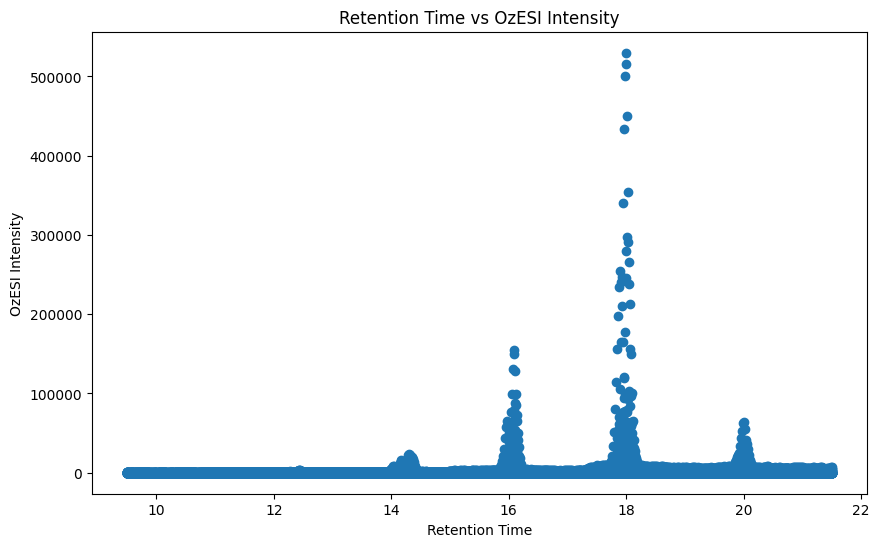

In [12]:



# Assuming clustered_data is your DataFrame with the necessary data

# Plotting the Intensity vs Retention Time
plt.figure(figsize=(10, 6))
plt.scatter(d1a['Retention_Time'], d1a['OzESI_Intensity'])

# Adding labels and title to the plot
plt.xlabel('Retention Time')
plt.ylabel('OzESI Intensity')
plt.title('Retention Time vs OzESI Intensity')

# Displaying the plot
plt.show()


In [13]:
# # Assuming d1 is your DataFrame and contains 'Retention_Time', 'Parent_Ion', 'Product_Ion', and 'OzESI_Intensity' columns

# # Define the retention time range
# retention_time_range = (12, 16)

# # Filter to get only the rows where 'db' is 'n-7'
# n7_values = d1[(d1['Retention_Time'] >= retention_time_range[0]) & (d1['Retention_Time'] <= retention_time_range[1])]

# # Filter to get only the rows with specific transition and OzESI_Intensity > 500
# specific_transition = n7_values[(n7_values['Parent_Ion'] == 790.7) & (n7_values['Product_Ion'] == 573.6) & (n7_values['OzESI_Intensity'] > 300)]

# # Display the filtered DataFrame
# specific_transition.tail(50)

Correct RTs add DB position based on correct RT

In [14]:
Correct_RT_directory = 'tools/RT/'
#MRM CORRECT RT DF
df_MRM_RT_correct = pd.read_csv(Correct_RT_directory + 'CLAW_Canola_CorrectRT_v3_manual.csv') #correct MRM RT
# df_MRM_RT_correct['Retention_Time'] = df_MRM_RT_correct['Average_Retention_Time']

# List of new column names based on db_pos_list
db_column_names = []
db_pos_list = [7, 9, 10, 12]


df_DB_aldehyde = pd.DataFrame(columns=['DB_Position','Aldehyde_Ion'])

# Loop through the range of DB_Position values to calculate the corresponding Aldehyde_Ion values
for position in range(3, 21):
    df_DB_aldehyde.loc[position, 'DB_Position'] = position
    df_DB_aldehyde.loc[position, 'Aldehyde_Ion'] = 26 + (14 * (position-3))

for number in db_pos_list:
    db_column_names.append(f'n-{number}')

# Create an empty DataFrame with initial columns
df_db_pos = pd.DataFrame(columns=['Lipid', 'Retention_Time', 'Parent_Ion','Product_Ion'])

# Append new column names to the DataFrame
for column_name in db_column_names:
    df_db_pos[column_name] = pd.NA  # Initialize the new columns with NA

# df_DB_aldehyde #aldehyde ion values


#append df_MRM_RT_correct to df_db_pos
df_db_pos = df_db_pos.append(df_MRM_RT_correct, ignore_index=True)


# Loop through the specified db_pos_list
for ozesi_position in db_pos_list:
    # Retrieve the corresponding Aldehyde_Ion value for the current DB_Position
    aldehyde_ion = df_DB_aldehyde.loc[df_DB_aldehyde["DB_Position"] == ozesi_position, "Aldehyde_Ion"].values[0]

    # Calculate and store the n-i value for the current OzESI position
    df_db_pos["n-{}".format(ozesi_position)] = df_db_pos["Parent_Ion"] - aldehyde_ion


    
def determine_fac(lipid):
    if isinstance(lipid, str):  # Check if the input is a string
        if 'FA18:1' in lipid:
            return 'FA18:1'
        elif 'FA16:1' in lipid:
            return 'FA16:1'
    return None  # Return None or some other default value for non-string inputs

# Convert the 'Lipid' column to string
df_db_pos['Lipid'] = df_db_pos['Lipid'].astype(str)

# Apply the function to the Lipid column to create the FAC column
df_db_pos['FAC'] = df_db_pos['Lipid'].apply(determine_fac)


#### sort df_db_pos
# Function to extract TG values
def extract_tg(lipid):
    # Regular expression pattern to match TG(##:#) or similar patterns
    pattern = r'TG\(\d+:\d+\)'
    matches = re.findall(pattern, lipid)
    return ', '.join(matches) if matches else None

# Apply the function to the Lipid column to create the TG column
df_db_pos['TG'] = df_db_pos['Lipid'].apply(extract_tg)




# Function to sort TG values within a cell
def sort_tg_values(tg_cell):
    if not pd.isna(tg_cell) and ', ' in tg_cell:
        tg_list = tg_cell.split(', ')
        tg_list_sorted = sorted(tg_list, key=lambda x: [int(i) for i in x[3:-1].split(':')])
        return ', '.join(tg_list_sorted)
    else:
        return tg_cell
    
# Function to remove TG(##:0) patterns from the Lipid string
def remove_tg_zero(lipid):
    # Pattern to match TG(##:0)
    pattern = r'TG\(\d+:0\)'
    # Remove TG(##:0) patterns
    new_lipid = re.sub(pattern, '', lipid)
    # Remove any extra commas and spaces left after removal
    new_lipid = re.sub(r',\s+', ', ', new_lipid).strip(', ')
    return new_lipid

df_db_pos['Lipid'] = df_db_pos['Lipid'].apply(remove_tg_zero)
    
df_db_pos['TG'] = df_db_pos['TG'].apply(sort_tg_values)
#sort by FAC then TG
df_db_pos.sort_values(by=['FAC', 'TG'], inplace=True)


# df_db_pos.to_excel('CLAW_CanolaOzON.xlsx')
df_db_pos


,Lipid,Retention_Time,Parent_Ion,Product_Ion,n-7,n-9,n-10,n-12,FAC,TG
3,"[TG(53:9),TG(52:2)]_FA18:1",18.04,876.8,577.6,794.8,766.8,752.8,724.8,FA18:1,"TG(52:2), TG(53:9)"
2,"[TG(53:10),TG(52:3)]_FA18:1",16.12,874.8,575.6,792.8,764.8,750.8,722.8,FA18:1,"TG(52:3), TG(53:10)"
0,[TG(52:4)]_FA18:1,14.32,872.8,573.6,790.8,762.8,748.8,720.8,FA18:1,TG(52:4)
1,[TG(52:5)]_FA18:1,12.59,870.8,571.6,788.8,760.8,746.8,718.8,FA18:1,TG(52:5)
6,"[TG(54:7),]_FA18:1",10.73,894.8,595.6,812.8,784.8,770.8,742.8,FA18:1,"TG(53:0), TG(54:7)"
9,"[TG(55:9),TG(54:2)]_FA18:1",20.00,904.8,605.6,822.8,794.8,780.8,752.8,FA18:1,"TG(54:2), TG(55:9)"
7,"[TG(55:10),TG(54:3)]_FA18:1",17.99,902.8,603.6,820.8,792.8,778.8,750.8,FA18:1,"TG(54:3), TG(55:10)"
8,"[TG(55:11),TG(54:4)]_FA18:1",16.08,900.8,601.6,818.8,790.8,776.8,748.8,FA18:1,"TG(54:4), TG(55:11)"
4,[TG(54:5)]_FA18:1,14.30,898.8,599.6,816.8,788.8,774.8,746.8,FA18:1,TG(54:5)
5,[TG(54:6)]_FA18:1,12.43,896.8,597.6,814.8,786.8,772.8,744.8,FA18:1,TG(54:6)


# Set RT Window around Ground Truth and Filter through filtered_d1 based on matched OzOFF lipids df_db_pos

In [15]:
# Assuming df_db_pos and filtered_d1 are your DataFrames

tolerance = 0.3
retention_time_tolerance = 0.65  # Adjust this value as needed

# Re-initializing an empty DataFrame for filtered_d2
d2 = pd.DataFrame()

# Iterating through df_db_pos
for index, row in df_db_pos.iterrows():
    ground_truth_retention_time = row['Retention_Time']  # Ground truth retention time
    product_ion = row['Product_Ion']
    parent_ion_n7 = row['n-7']
    parent_ion_n9 = row['n-9']
    parent_ion_n10 = row['n-10']
    parent_ion_n12 = row['n-12']
    lipid_name = row['Lipid']  # Extracting Lipid name from df_db_pos

    # Defining the retention time window based on ground truth
    lower_bound_time = ground_truth_retention_time - retention_time_tolerance
    upper_bound_time = ground_truth_retention_time + retention_time_tolerance

    # Defining the tolerance for Parent and Product ions
    lower_bound_ion = product_ion - tolerance
    upper_bound_ion = product_ion + tolerance

    # Filtering filtered_d1 within the specified window and matching ions with tolerance
    matches = d1a[(d1a['Retention_Time'] >= lower_bound_time) & 
                        (d1a['Retention_Time'] <= upper_bound_time) &
                        (d1a['OzESI_Intensity'] >= 5) &
                        (d1a['Product_Ion'] >= lower_bound_ion) &
                        (d1a['Product_Ion'] <= upper_bound_ion)]

    # Adding 'db' and 'Lipid' columns based on the tolerance matching
    matches['db'] = ''
    matches['Lipid'] = lipid_name  # Adding the Lipid name to all matches
    matches.loc[(matches['Parent_Ion'] >= parent_ion_n7 - tolerance) & 
                (matches['Parent_Ion'] <= parent_ion_n7 + tolerance), 'db'] = 'n-7'
    matches.loc[(matches['Parent_Ion'] >= parent_ion_n9 - tolerance) & 
                (matches['Parent_Ion'] <= parent_ion_n9 + tolerance), 'db'] = 'n-9'
    matches.loc[(matches['Parent_Ion'] >= parent_ion_n10 - tolerance) & 
                (matches['Parent_Ion'] <= parent_ion_n10 + tolerance), 'db'] = 'n-10'
    matches.loc[(matches['Parent_Ion'] >= parent_ion_n12 - tolerance) & 
                (matches['Parent_Ion'] <= parent_ion_n12 + tolerance), 'db'] = 'n-12'

    # Append the matching rows to filtered_d2
    d2 = d2.append(matches)

# Resetting the index of the new DataFrame
d2 = d2.reset_index(drop=True)

# Display the first few rows of the new DataFrame
d2


/home/iyer95/.conda/envs/CLA/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/iyer95/.conda/envs/CLA/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/iyer95/.conda/envs/CLA/lib/python3.7/site-packages/pandas/core/indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,db,Lipid
0,766.7,577.6,17.398783,1312.200073,CrudeCanola_O3on_150gN3_02082023,766.7 -> 577.6,n-9,"[TG(53:9),TG(52:2)]_FA18:1"
1,766.7,577.6,17.415100,1483.680054,CrudeCanola_O3on_150gN3_02082023,766.7 -> 577.6,n-9,"[TG(53:9),TG(52:2)]_FA18:1"
2,766.7,577.6,17.431400,1617.760132,CrudeCanola_O3on_150gN3_02082023,766.7 -> 577.6,n-9,"[TG(53:9),TG(52:2)]_FA18:1"
3,766.7,577.6,17.447717,1527.580078,CrudeCanola_O3on_150gN3_02082023,766.7 -> 577.6,n-9,"[TG(53:9),TG(52:2)]_FA18:1"
4,766.7,577.6,17.464017,1344.940063,CrudeCanola_O3on_150gN3_02082023,766.7 -> 577.6,n-9,"[TG(53:9),TG(52:2)]_FA18:1"
...,...,...,...,...,...,...,...,...
7168,896.8,597.6,12.999400,288.920013,RBDCanola_O3on_150gN3_02082023,896.8 -> 597.6,,[TG(54:6)]_FA18:1
7169,896.8,597.6,13.015700,212.680008,RBDCanola_O3on_150gN3_02082023,896.8 -> 597.6,,[TG(54:6)]_FA18:1
7170,896.8,597.6,13.032017,216.600021,RBDCanola_O3on_150gN3_02082023,896.8 -> 597.6,,[TG(54:6)]_FA18:1
7171,896.8,597.6,13.048317,164.280014,RBDCanola_O3on_150gN3_02082023,896.8 -> 597.6,,[TG(54:6)]_FA18:1


CHeck RT of a specific lipid

In [16]:
# Filter the DataFrame based on the specified conditions

# Filter the DataFrame based on the specified conditions
filtered_df = d2[(d2['Lipid'].str.contains('TG\(54:2\)'))]

# Print the filtered values
filtered_df

,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,db,Lipid
3585,794.6,605.6,19.350650,613.320068,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1"
3586,794.6,605.6,19.366950,674.020020,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1"
3587,794.6,605.6,19.383250,740.760071,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1"
3588,794.6,605.6,19.399567,757.960083,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1"
3589,794.6,605.6,19.415867,713.660034,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1"
...,...,...,...,...,...,...,...,...
4297,904.8,605.6,20.580700,3088.660156,RBDCanola_O3on_150gN3_02082023,904.8 -> 605.6,,"[TG(55:9),TG(54:2)]_FA18:1"
4298,904.8,605.6,20.597017,2819.220215,RBDCanola_O3on_150gN3_02082023,904.8 -> 605.6,,"[TG(55:9),TG(54:2)]_FA18:1"
4299,904.8,605.6,20.613317,2605.540283,RBDCanola_O3on_150gN3_02082023,904.8 -> 605.6,,"[TG(55:9),TG(54:2)]_FA18:1"
4300,904.8,605.6,20.629633,2832.960205,RBDCanola_O3on_150gN3_02082023,904.8 -> 605.6,,"[TG(55:9),TG(54:2)]_FA18:1"


Check specific transition RT for validate RT

In [17]:
# Assuming filtered_d2 is already created and contains the 'db' column

# Filter to get only the rows where 'db' is 'n-7'
n7_values = d2[d2['db'] == 'n-7']

# Filter to get only the rows with specific transition: Parent_Ion 788.7 to Product_Ion 599.5
specific_transition = n7_values[(n7_values['Parent_Ion'] == 790.7) & (n7_values['Product_Ion'] == 573.6)]

specific_transition


,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,db,Lipid
1514,790.7,573.6,13.676867,154.020004,CrudeCanola_O3on_150gN3_02082023,790.7 -> 573.6,n-7,[TG(52:4)]_FA18:1
1515,790.7,573.6,13.693183,177.720016,CrudeCanola_O3on_150gN3_02082023,790.7 -> 573.6,n-7,[TG(52:4)]_FA18:1
1516,790.7,573.6,13.709483,178.320007,CrudeCanola_O3on_150gN3_02082023,790.7 -> 573.6,n-7,[TG(52:4)]_FA18:1
1517,790.7,573.6,13.725783,147.220016,CrudeCanola_O3on_150gN3_02082023,790.7 -> 573.6,n-7,[TG(52:4)]_FA18:1
1518,790.7,573.6,13.742100,148.900009,CrudeCanola_O3on_150gN3_02082023,790.7 -> 573.6,n-7,[TG(52:4)]_FA18:1
...,...,...,...,...,...,...,...,...
2067,790.7,573.6,14.899967,193.620010,RBDCanola_O3on_150gN3_02082023,790.7 -> 573.6,n-7,[TG(52:4)]_FA18:1
2068,790.7,573.6,14.916267,145.440018,RBDCanola_O3on_150gN3_02082023,790.7 -> 573.6,n-7,[TG(52:4)]_FA18:1
2069,790.7,573.6,14.932583,173.140015,RBDCanola_O3on_150gN3_02082023,790.7 -> 573.6,n-7,[TG(52:4)]_FA18:1
2070,790.7,573.6,14.948883,197.520020,RBDCanola_O3on_150gN3_02082023,790.7 -> 573.6,n-7,[TG(52:4)]_FA18:1


# Determine Groups

In [18]:
# Creating filtered_d3 from filtered_d2
d3 = d2.copy()

# Function to determine the value for the Purity column
def determine_purity(sample_id):
    if 'Crude' in sample_id:
        return 'Crude'
    elif 'Degummed' in sample_id:
        return 'Degummed'
    elif 'RBD' in sample_id:
        return 'RBD'
    else:
        return None  # or some other default value if needed

# Apply the function to the Sample_ID column to create the Purity column
d3['Purity'] = d3['Sample_ID'].apply(determine_purity)
d3

# # Function to remove the first TG if there are two TGs
# def remove_first_tg(lipid):
#     tg_parts = lipid.split(',')
#     if len(tg_parts) > 1:
#         return '[' + tg_parts[1]
#     else:
#         return lipid
    
# Function to determine the value for the FAC column
def determine_fac(lipid):
    if 'FA18:1' in lipid:
        return 'FA18:1'
    elif 'FA16:1' in lipid:
        return 'FA16:1'
    else:
        return None  # or some other default value

# Apply the function to the Lipid column to create the FAC column
d3['FAC'] = d3['Lipid'].apply(determine_fac)

import pandas as pd
import re

# Function to extract TG values
def extract_tg(lipid):
    # Regular expression pattern to match TG(##:#) or similar patterns
    pattern = r'TG\(\d+:\d+\)'
    matches = re.findall(pattern, lipid)
    return ', '.join(matches) if matches else None

# Apply the function to the Lipid column to create the TG column
d3['TG'] = d3['Lipid'].apply(extract_tg)




# Function to sort TG values within a cell
def sort_tg_values(tg_cell):
    if not pd.isna(tg_cell) and ', ' in tg_cell:
        tg_list = tg_cell.split(', ')
        tg_list_sorted = sorted(tg_list, key=lambda x: [int(i) for i in x[3:-1].split(':')])
        return ', '.join(tg_list_sorted)
    else:
        return tg_cell

# Apply the function to the TG column
d3['TG'] = d3['TG'].apply(sort_tg_values)
d3 = d3.sort_values(by=['FAC', 'TG'])



# Sorting by 'Purity' and then by 'Lipid'
d3 = d3.sort_values(by=['Purity', 'Lipid'])

grouped_cluster_data = d3.groupby(['Lipid','db','Purity','Sample_ID'])
#add group number to each to a new column called Group
d3['Group'] = grouped_cluster_data.ngroup()
d3



,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,db,Lipid,Purity,FAC,TG,Group
1434,762.6,573.6,13.681500,250.220016,CrudeCanola_O3on_150gN3_02082023,762.6 -> 573.6,n-9,[TG(52:4)]_FA18:1,Crude,FA18:1,TG(52:4),6
1435,762.6,573.6,13.697817,200.780014,CrudeCanola_O3on_150gN3_02082023,762.6 -> 573.6,n-9,[TG(52:4)]_FA18:1,Crude,FA18:1,TG(52:4),6
1436,762.6,573.6,13.714117,186.040009,CrudeCanola_O3on_150gN3_02082023,762.6 -> 573.6,n-9,[TG(52:4)]_FA18:1,Crude,FA18:1,TG(52:4),6
1437,762.6,573.6,13.730433,208.120010,CrudeCanola_O3on_150gN3_02082023,762.6 -> 573.6,n-9,[TG(52:4)]_FA18:1,Crude,FA18:1,TG(52:4),6
1438,762.6,573.6,13.746733,191.700012,CrudeCanola_O3on_150gN3_02082023,762.6 -> 573.6,n-9,[TG(52:4)]_FA18:1,Crude,FA18:1,TG(52:4),6
...,...,...,...,...,...,...,...,...,...,...,...,...
4297,904.8,605.6,20.580700,3088.660156,RBDCanola_O3on_150gN3_02082023,904.8 -> 605.6,,"[TG(55:9),TG(54:2)]_FA18:1",RBD,FA18:1,"TG(54:2), TG(55:9)",83
4298,904.8,605.6,20.597017,2819.220215,RBDCanola_O3on_150gN3_02082023,904.8 -> 605.6,,"[TG(55:9),TG(54:2)]_FA18:1",RBD,FA18:1,"TG(54:2), TG(55:9)",83
4299,904.8,605.6,20.613317,2605.540283,RBDCanola_O3on_150gN3_02082023,904.8 -> 605.6,,"[TG(55:9),TG(54:2)]_FA18:1",RBD,FA18:1,"TG(54:2), TG(55:9)",83
4300,904.8,605.6,20.629633,2832.960205,RBDCanola_O3on_150gN3_02082023,904.8 -> 605.6,,"[TG(55:9),TG(54:2)]_FA18:1",RBD,FA18:1,"TG(54:2), TG(55:9)",83


# GMM

In [19]:

# Assuming d3 is your DataFrame
d4 = pd.DataFrame()  # Initialize an empty DataFrame to store clustered results

# Iterate over each group in the 'Group' column
for group_id, group in d3.groupby(['Group']):
    # Calculate 1% below the maximum 'OzESI_Intensity'
    max_intensity = group['OzESI_Intensity'].max()
    cutoff_intensity = max_intensity * 0.00005

    # Apply the filters
    filtered_group = group[(group['OzESI_Intensity'] >= cutoff_intensity) & (group['OzESI_Intensity'] > 0)]

    # Check if the filtered group is empty or has less than 2 samples
    if filtered_group.empty or len(filtered_group) < 2:
        continue

    # Reshape the 'Retention_Time' data for GMM
    retention_times = filtered_group[['Retention_Time']].values

    # Apply GMM clustering to this specific group
    # Note: Adjust the number of components (n_components) as needed
    gmm = GaussianMixture(n_components=3, covariance_type='full').fit(retention_times)

    # Get the cluster labels
    labels = gmm.predict(retention_times)

    # Add the cluster labels to the filtered group
    filtered_group['Cluster_Label'] = labels

    # Append the clustered group to the results DataFrame
    d4 = pd.concat([d4, filtered_group])

# The resulting DataFrame, d4, now contains separately clustered data for each group


# CHeck GMM Clusters

In [334]:
# Filter the DataFrame based on Lipid, Purity, db, and Retention_Time conditions
d5 = d4.copy()  # Assuming d4 is your original DataFrame

# Filter the DataFrame based on Lipid and Purity = Crude and db = n-9, and Retention_Time between 19.5 and 20.5
filtered_df = d5[(d5['Lipid'].str.contains('TG\(54:2\)')) & 
                 (d5['Purity'].str.contains('Crude')) & 
                 (d5['db'].str.contains('n-9')) & 
                 (d5['Retention_Time'] >= 19.74) & 
                 (d5['Retention_Time'] <= 20.28)]

# Print the filtered values
#print len(filtered_df)
print(len(filtered_df))
filtered_df


33


,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,db,Lipid,Purity,FAC,TG,Group,Cluster_Label
3609,794.6,605.6,19.742033,916.180054,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,0
3610,794.6,605.6,19.758333,809.420044,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,0
3611,794.6,605.6,19.774650,837.340088,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,2
3612,794.6,605.6,19.790950,1106.740112,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,2
3613,794.6,605.6,19.807267,1130.460083,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,2
3614,794.6,605.6,19.823567,1308.420044,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,2
3615,794.6,605.6,19.839883,1207.040039,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,2
3616,794.6,605.6,19.856183,1320.160034,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,2
3617,794.6,605.6,19.872500,1294.200073,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,2
3618,794.6,605.6,19.888800,1631.600098,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,2


Single GMM

In [21]:
import pandas as pd
from sklearn.mixture import GaussianMixture

# Assuming d3 is your DataFrame
d_single = pd.DataFrame()  # Initialize an empty DataFrame to store the result for a single group

# Specify the group to perform GMM on
specified_group = 87  # Replace 'Your_Group_ID' with the desired group identifier

# Check if the specified group exists in d3
if specified_group in d3['Group'].unique():
    # Filter the DataFrame for the specified group
    group = d3[d3['Group'] == specified_group]

    # Calculate 1% below the maximum 'OzESI_Intensity'
    max_intensity = group['OzESI_Intensity'].max()
    cutoff_intensity = max_intensity * 0.00005

    # Apply the filters
    filtered_group = group[(group['OzESI_Intensity'] >= cutoff_intensity) & (group['OzESI_Intensity'] > 0)]

    # Proceed only if the filtered group is not empty and has more than 1 sample
    if not filtered_group.empty and len(filtered_group) >= 2:
        # Reshape the 'Retention_Time' data for GMM
        retention_times = filtered_group[['Retention_Time']].values

        # Apply GMM clustering to this specific group
        # Note: Adjust the number of components (n_components) as needed
        gmm = GaussianMixture(n_components=3, covariance_type='full').fit(retention_times)

        # Get the cluster labels
        labels = gmm.predict(retention_times)

        # Add the cluster labels to the filtered group
        filtered_group['Cluster_Label'] = labels

        # Save the clustered group to d_single DataFrame
        d_single = filtered_group

else:
    print(f"Group '{specified_group}' not found in the DataFrame.")

# The resulting DataFrame, d_single, now contains clustered data for the specified group


# Plot GMM Cluster check for specific lipid

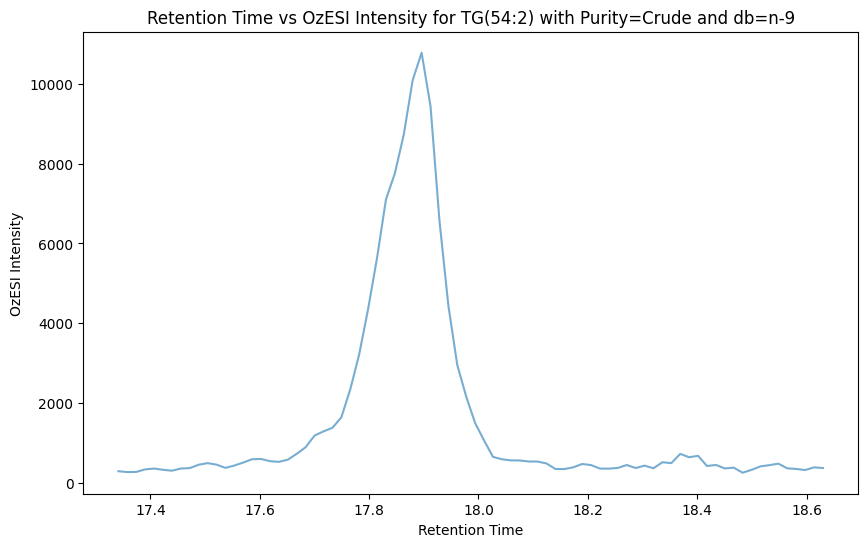

In [22]:
import matplotlib.pyplot as plt

# Filter the DataFrame based on the specified conditions
filtered_df = d5[(d5['Lipid'].str.contains('TG\(54:3\)')) & 
                 (d5['Purity'].str.contains('Degummed')) & 
                 (d5['db'].str.contains('n-7'))]

# Plotting the filtered data
plt.figure(figsize=(10, 6))
plt.plot(filtered_df['Retention_Time'], filtered_df['OzESI_Intensity'], alpha=0.6)
plt.xlabel('Retention Time')
plt.ylabel('OzESI Intensity')
plt.title('Retention Time vs OzESI Intensity for TG(54:2) with Purity=Crude and db=n-9')
plt.show()


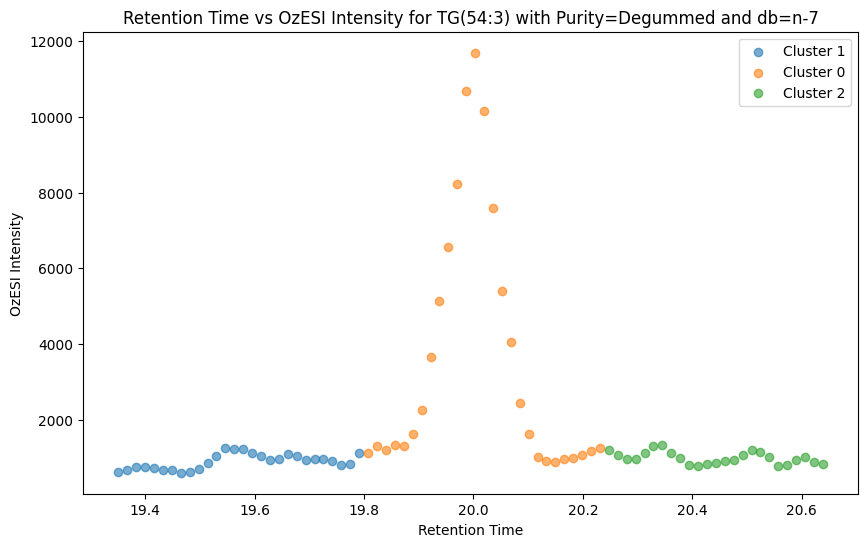

In [23]:
import matplotlib.pyplot as plt

# Filter the DataFrame based on the specified conditions
filtered_df = d_single[(d_single['Lipid'].str.contains('TG\(54:2\)')) & 
                 (d_single['Purity'].str.contains('Crude')) & 
                 (d_single['db'].str.contains('n-9'))]

# Plotting the filtered data with colors based on Cluster_Label
plt.figure(figsize=(10, 6))

# Iterate through each unique value in the Cluster_Label column
for label in filtered_df['Cluster_Label'].unique():
    # Filter the DataFrame for each label
    cluster_df = filtered_df[filtered_df['Cluster_Label'] == label]
    
    # Plot each cluster with a different color
    plt.scatter(cluster_df['Retention_Time'], cluster_df['OzESI_Intensity'], alpha=0.6, label=f'Cluster {label}')

plt.xlabel('Retention Time')
plt.ylabel('OzESI Intensity')
plt.title('Retention Time vs OzESI Intensity for TG(54:3) with Purity=Degummed and db=n-7')
plt.legend()
plt.show()


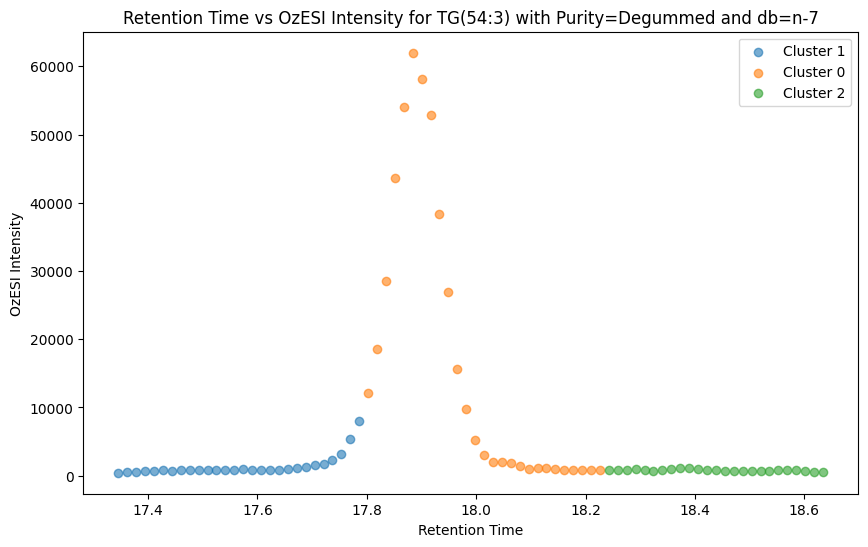

In [24]:
import matplotlib.pyplot as plt

# Filter the DataFrame based on the specified conditions
filtered_df = d5[(d5['Lipid'].str.contains('TG\(54:3\)')) & 
                 (d5['Purity'].str.contains('Degummed')) & 
                 (d5['db'].str.contains('n-9'))]

# Plotting the filtered data with colors based on Cluster_Label
plt.figure(figsize=(10, 6))

# Iterate through each unique value in the Cluster_Label column
for label in filtered_df['Cluster_Label'].unique():
    # Filter the DataFrame for each label
    cluster_df = filtered_df[filtered_df['Cluster_Label'] == label]
    
    # Plot each cluster with a different color
    plt.scatter(cluster_df['Retention_Time'], cluster_df['OzESI_Intensity'], alpha=0.6, label=f'Cluster {label}')

plt.xlabel('Retention Time')
plt.ylabel('OzESI Intensity')
plt.title('Retention Time vs OzESI Intensity for TG(54:3) with Purity=Degummed and db=n-7')
plt.legend()
plt.show()


In [25]:
# # Assuming clustered_data is your DataFrame with the necessary data

# # Plotting the Intensity vs Retention Time
# plt.figure(figsize=(10, 6))
# plt.scatter(d4['Retention_Time'], d4['OzESI_Intensity'])

# # Adding labels and title to the plot
# plt.xlabel('Retention Time')
# plt.ylabel('OzESI Intensity')
# plt.title('Retention Time vs OzESI Intensity')

# # Displaying the plot
# plt.show()


# Find max intensity and remove clusters without db

In [26]:
d6 = d5.copy()

# Group by 'Group' and 'Cluster_Label' and find the maximum 'OzESI_Intensity' for each group
max_intensity_group = d5.groupby(['Group', 'Cluster_Label'])['OzESI_Intensity'].max().reset_index()

# Rename the column to 'Max_Intensity'
max_intensity_group = max_intensity_group.rename(columns={'OzESI_Intensity': 'Max_Intensity'})

# Merge the maximum intensity data back into the original DataFrame
d6 = d6.merge(max_intensity_group, on=['Group', 'Cluster_Label'])
#round max intensity to 0 decimal places
d6['Max_Intensity'] = d6['Max_Intensity'].round(0)
# Display the DataFrame

d6 = d6[d6['db'] != '']
d6
#####

# import pandas as pd



# # Copying d5 to d6
# d6 = d5.copy()

# # Check the initial maximum intensity for Group 87
# initial_max_group_87 = d5[d5['Group'] == 87]['OzESI_Intensity'].max()
# print(f"Initial max intensity for Group 87: {initial_max_group_87}")

# # Group by 'Group' and 'Cluster_Label' and find the maximum 'OzESI_Intensity' for each group
# max_intensity_group = d5.groupby(['Group', 'Cluster_Label'])['OzESI_Intensity'].max().reset_index()

# # Rename the column to 'Max_Intensity'
# max_intensity_group = max_intensity_group.rename(columns={'OzESI_Intensity': 'Max_Intensity'})

# # Check the calculated maximum intensity for Group 87
# calculated_max_group_87 = max_intensity_group[max_intensity_group['Group'] == 87]['Max_Intensity'].max()
# print(f"Calculated max intensity for Group 87: {calculated_max_group_87}")

# # Merge the maximum intensity data back into the original DataFrame
# d6 = d6.merge(max_intensity_group, on=['Group', 'Cluster_Label'])

# # Check the maximum intensity for Group 87 after merging
# merged_max_group_87 = d6[d6['Group'] == 87]['Max_Intensity'].max()
# print(f"Merged max intensity for Group 87: {merged_max_group_87}")

# # Round max intensity to 0 decimal places
# d6['Max_Intensity'] = d6['Max_Intensity'].round(0)

# # Check the maximum intensity for Group 87 after rounding
# rounded_max_group_87 = d6[d6['Group'] == 87]['Max_Intensity'].max()
# print(f"Rounded max intensity for Group 87: {rounded_max_group_87}")

# # Filter the DataFrame
# d6 = d6[d6['db'] != '']

# # Check the maximum intensity for Group 87 after filtering
# filtered_max_group_87 = d6[d6['Group'] == 87]['Max_Intensity'].max()
# print(f"Filtered max intensity for Group 87: {filtered_max_group_87}")

# # Display the DataFrame
# # print(d6) # Uncomment this line to display the DataFrame



,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,db,Lipid,Purity,FAC,TG,Group,Cluster_Label,Max_Intensity
237,790.7,573.6,13.676867,154.020004,CrudeCanola_O3on_150gN3_02082023,790.7 -> 573.6,n-7,[TG(52:4)]_FA18:1,Crude,FA18:1,TG(52:4),3,1,253.0
238,790.7,573.6,13.693183,177.720016,CrudeCanola_O3on_150gN3_02082023,790.7 -> 573.6,n-7,[TG(52:4)]_FA18:1,Crude,FA18:1,TG(52:4),3,1,253.0
239,790.7,573.6,13.709483,178.320007,CrudeCanola_O3on_150gN3_02082023,790.7 -> 573.6,n-7,[TG(52:4)]_FA18:1,Crude,FA18:1,TG(52:4),3,1,253.0
240,790.7,573.6,13.725783,147.220016,CrudeCanola_O3on_150gN3_02082023,790.7 -> 573.6,n-7,[TG(52:4)]_FA18:1,Crude,FA18:1,TG(52:4),3,1,253.0
241,790.7,573.6,13.742100,148.900009,CrudeCanola_O3on_150gN3_02082023,790.7 -> 573.6,n-7,[TG(52:4)]_FA18:1,Crude,FA18:1,TG(52:4),3,1,253.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7168,794.6,605.6,20.573733,920.700073,RBDCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",RBD,FA18:1,"TG(54:2), TG(55:9)",89,0,1315.0
7169,794.6,605.6,20.590033,928.060059,RBDCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",RBD,FA18:1,"TG(54:2), TG(55:9)",89,0,1315.0
7170,794.6,605.6,20.606350,998.960083,RBDCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",RBD,FA18:1,"TG(54:2), TG(55:9)",89,0,1315.0
7171,794.6,605.6,20.622650,1023.520081,RBDCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",RBD,FA18:1,"TG(54:2), TG(55:9)",89,0,1315.0


In [27]:
d6[d6['Group'] == 87]['OzESI_Intensity'].max()
d6[d6['Group'] == 87]
#check group 87 cluster 0
d6[(d6['Group'] == 87) & (d6['Cluster_Label'] == 0)]

,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,db,Lipid,Purity,FAC,TG,Group,Cluster_Label,Max_Intensity
6933,794.6,605.6,19.350650,613.320068,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,0,1245.0
6934,794.6,605.6,19.366950,674.020020,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,0,1245.0
6935,794.6,605.6,19.383250,740.760071,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,0,1245.0
6936,794.6,605.6,19.399567,757.960083,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,0,1245.0
6937,794.6,605.6,19.415867,713.660034,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,0,1245.0
6938,794.6,605.6,19.432183,674.160034,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,0,1245.0
6939,794.6,605.6,19.448483,669.640076,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,0,1245.0
6940,794.6,605.6,19.464800,598.300049,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,0,1245.0
6941,794.6,605.6,19.481100,628.020020,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,0,1245.0
6942,794.6,605.6,19.497417,692.340027,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,0,1245.0


# Keep Cluster with highest max intensity, remove other clusters

In [28]:
d7 = d6.copy()
df_all_clusters = d6.copy()
# Step 1: Identify the Cluster_Label with the highest Max_Intensity for each Group
max_intensity_label_per_group = d7.groupby('Group').apply(lambda x: x['Cluster_Label'][x['Max_Intensity'].idxmax()])

# Step 2: Filter the original DataFrame
d7 = d7[d7.apply(lambda row: row['Cluster_Label'] == max_intensity_label_per_group[row['Group']], axis=1)]

# Filter out group-cluster pairs where the maximum intensity (Max_Intensity) is 500 or less
valid_pairs = d7[d7['Max_Intensity'] > 300]

# The resulting DataFrame, valid_pairs, now contains data for group-cluster pairs meeting the intensity criterion
d7 = valid_pairs

# Display the filtered DataFrame
d7



,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,db,Lipid,Purity,FAC,TG,Group,Cluster_Label,Max_Intensity
264,790.7,573.6,14.117183,219.460022,CrudeCanola_O3on_150gN3_02082023,790.7 -> 573.6,n-7,[TG(52:4)]_FA18:1,Crude,FA18:1,TG(52:4),3,0,615.0
265,790.7,573.6,14.133483,214.400009,CrudeCanola_O3on_150gN3_02082023,790.7 -> 573.6,n-7,[TG(52:4)]_FA18:1,Crude,FA18:1,TG(52:4),3,0,615.0
266,790.7,573.6,14.149800,227.580017,CrudeCanola_O3on_150gN3_02082023,790.7 -> 573.6,n-7,[TG(52:4)]_FA18:1,Crude,FA18:1,TG(52:4),3,0,615.0
267,790.7,573.6,14.166100,259.420013,CrudeCanola_O3on_150gN3_02082023,790.7 -> 573.6,n-7,[TG(52:4)]_FA18:1,Crude,FA18:1,TG(52:4),3,0,615.0
268,790.7,573.6,14.182417,231.680023,CrudeCanola_O3on_150gN3_02082023,790.7 -> 573.6,n-7,[TG(52:4)]_FA18:1,Crude,FA18:1,TG(52:4),3,0,615.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7142,794.6,605.6,20.149717,1227.640137,RBDCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",RBD,FA18:1,"TG(54:2), TG(55:9)",89,2,7721.0
7143,794.6,605.6,20.166033,1137.340088,RBDCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",RBD,FA18:1,"TG(54:2), TG(55:9)",89,2,7721.0
7144,794.6,605.6,20.182333,1039.920044,RBDCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",RBD,FA18:1,"TG(54:2), TG(55:9)",89,2,7721.0
7145,794.6,605.6,20.198650,1225.180054,RBDCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",RBD,FA18:1,"TG(54:2), TG(55:9)",89,2,7721.0


In [29]:
# d7[d7['Group'] == 87]


# Set Peak Boundaries using Peak Width at % of Peak Height

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

# Assuming d7 is already defined
d8 = d7.copy()

# Define the directory where you want to save the plots
save_directory = 'Projects/canola/plots/peak_check/width/'
os.makedirs(save_directory, exist_ok=True)

# Setting parameters for peak finding
peak_width_fraction = 0.01

# Function to calculate peak boundaries
def calculate_peak_boundaries(intensities, times, peak_max_index):
    peak_max_intensity = intensities[peak_max_index]
    intensity_threshold = peak_max_intensity * peak_width_fraction

    left_indices = np.where(intensities[:peak_max_index] < intensity_threshold)[0]
    right_indices = np.where(intensities[peak_max_index:] < intensity_threshold)[0] + peak_max_index

    peak_start = times[left_indices[-1]] if len(left_indices) > 0 else times[0]
    peak_end = times[right_indices[0]] if len(right_indices) > 0 else times[-1]

    return peak_start, peak_end

def plot_peak_and_boundaries(group_data, group, cluster_label, save_dir, peak_width_fraction=0.2):
    times = group_data['Retention_Time'].values
    intensities = group_data['OzESI_Intensity'].values
    peak_max_index = np.argmax(intensities)
    peak_start, peak_end = calculate_peak_boundaries(intensities, times, peak_max_index)

    # Extract additional information for the title
    lipid = group_data.iloc[0]['Lipid']
    purity = group_data.iloc[0]['Purity']
    db = group_data.iloc[0]['db']

    # # Plotting
    # plt.figure(figsize=(10, 6))
    # plt.plot(times, intensities, label='Intensity')
    # plt.scatter(times[peak_max_index], intensities[peak_max_index], color='red', label='Peak', zorder=5)
    # plt.axvline(peak_start, color='green', linestyle='--', label=f'Peak Start (Width at {peak_width_fraction*100:.0f}%)')
    # plt.axvline(peak_end, color='blue', linestyle='--', label=f'Peak End (Width at {peak_width_fraction*100:.0f}%)')
    # plt.xlabel('Retention Time')
    # plt.ylabel('OzESI Intensity')
    # plt.title(f'Group: {group}, Cluster: {cluster_label}, Lipid: {lipid}, Purity: {purity}, db: {db}')
    # plt.legend()

    # filename = f'Group: {group}, Cluster: {cluster_label}, Lipid: {lipid}, Purity: {purity}, db: {db}.png'
    # # plt.savefig(os.path.join(save_dir, filename), bbox_inches='tight')
    # # plt.show()
    # plt.close()

# Iterating over groups and clusters and plotting peaks
for (group, cluster_label), group_df in d8.groupby(['Group', 'Cluster_Label']):
    group_df_sorted = group_df.sort_values(by='Retention_Time')
    peak_max_index = np.argmax(group_df_sorted['OzESI_Intensity'].values)

    peak_start, peak_end = calculate_peak_boundaries(group_df_sorted['OzESI_Intensity'].values, 
                                                     group_df_sorted['Retention_Time'].values, 
                                                     peak_max_index)

    # Update d8 with peak boundaries
    d8.loc[(d8['Group'] == group) & (d8['Cluster_Label'] == cluster_label), 'RT_Start'] = peak_start.round(2)
    d8.loc[(d8['Group'] == group) & (d8['Cluster_Label'] == cluster_label), 'RT_End'] = peak_end.round(2)

    # Plot and save peak analysis with the correct peak_width_fraction
    plot_peak_and_boundaries(group_df_sorted, group, cluster_label, save_directory, peak_width_fraction)

# Now the plots will use the peak_width_fraction of 0.22 as intended


# # Display the updated DataFrame
# d8.head()


# Adjust new RTs based off peak width % calc

In [324]:
d9 = d8.copy()
d9
# Initialize an empty DataFrame to store the filtered results
filtered_d9 = pd.DataFrame()

# Iterate over each group-cluster pair
for (group, cluster_label), group_df in d9.groupby(['Group', 'Cluster_Label']):
    # Get the RT_Start and RT_End values for the current group-cluster pair
    rt_start = group_df['RT_Start'].iloc[0]
    rt_end = group_df['RT_End'].iloc[0]

    # Filter the DataFrame for rows where Retention_Time is within the start and end window
    within_window = group_df[(group_df['Retention_Time'] >= rt_start) & (group_df['Retention_Time'] <= rt_end)]

    # Append the filtered data to the results DataFrame
    filtered_d9 = pd.concat([filtered_d9, within_window])

# Assign the filtered DataFrame back to d9
d9 = filtered_d9

# Display the filtered DataFrame
d9




,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,db,Lipid,Purity,FAC,TG,Group,Cluster_Label,Max_Intensity,RT_Start,RT_End
265,790.7,573.6,14.133483,214.400009,CrudeCanola_O3on_150gN3_02082023,790.7 -> 573.6,n-7,[TG(52:4)]_FA18:1,Crude,FA18:1,TG(52:4),3,0,615.0,14.12,14.54
266,790.7,573.6,14.149800,227.580017,CrudeCanola_O3on_150gN3_02082023,790.7 -> 573.6,n-7,[TG(52:4)]_FA18:1,Crude,FA18:1,TG(52:4),3,0,615.0,14.12,14.54
267,790.7,573.6,14.166100,259.420013,CrudeCanola_O3on_150gN3_02082023,790.7 -> 573.6,n-7,[TG(52:4)]_FA18:1,Crude,FA18:1,TG(52:4),3,0,615.0,14.12,14.54
268,790.7,573.6,14.182417,231.680023,CrudeCanola_O3on_150gN3_02082023,790.7 -> 573.6,n-7,[TG(52:4)]_FA18:1,Crude,FA18:1,TG(52:4),3,0,615.0,14.12,14.54
269,790.7,573.6,14.198717,300.720032,CrudeCanola_O3on_150gN3_02082023,790.7 -> 573.6,n-7,[TG(52:4)]_FA18:1,Crude,FA18:1,TG(52:4),3,0,615.0,14.12,14.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7141,794.6,605.6,20.133417,1701.500122,RBDCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",RBD,FA18:1,"TG(54:2), TG(55:9)",89,2,7721.0,19.79,20.21
7142,794.6,605.6,20.149717,1227.640137,RBDCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",RBD,FA18:1,"TG(54:2), TG(55:9)",89,2,7721.0,19.79,20.21
7143,794.6,605.6,20.166033,1137.340088,RBDCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",RBD,FA18:1,"TG(54:2), TG(55:9)",89,2,7721.0,19.79,20.21
7144,794.6,605.6,20.182333,1039.920044,RBDCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",RBD,FA18:1,"TG(54:2), TG(55:9)",89,2,7721.0,19.79,20.21


In [325]:
# d9 group 3 max intensity
d9[d9['Group'] == 87]
# #print min OzESI_Intensity
# d9[d9['Group'] == 87]['OzESI_Intensity'].min()


,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,db,Lipid,Purity,FAC,TG,Group,Cluster_Label,Max_Intensity,RT_Start,RT_End
6959,794.6,605.6,19.774650,837.340088,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,2,11693.0,19.77,20.2
6960,794.6,605.6,19.790950,1106.740112,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,2,11693.0,19.77,20.2
6961,794.6,605.6,19.807267,1130.460083,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,2,11693.0,19.77,20.2
6962,794.6,605.6,19.823567,1308.420044,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,2,11693.0,19.77,20.2
6963,794.6,605.6,19.839883,1207.040039,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,2,11693.0,19.77,20.2
6964,794.6,605.6,19.856183,1320.160034,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,2,11693.0,19.77,20.2
6965,794.6,605.6,19.872500,1294.200073,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,2,11693.0,19.77,20.2
6966,794.6,605.6,19.888800,1631.600098,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,2,11693.0,19.77,20.2
6967,794.6,605.6,19.905117,2249.900146,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,2,11693.0,19.77,20.2
6968,794.6,605.6,19.921417,3651.000244,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,2,11693.0,19.77,20.2


# Add Clusters back for a specific group because GMM did not Cluster Properly

In [233]:
# def add_clusters(d9, df_all_clusters, group):
#     # Filter df_all_clusters for the specified group
#     group_data = df_all_clusters[df_all_clusters['Group'] == group]

#     # Append the data from the specified group back to d9
#     d9_updated = pd.concat([d9, group_data])

#     return d9_updated

# def merge_clusters(df, group):
#     # Filter the DataFrame for the specified group
#     group_data = df[df['Group'] == group]

#     # Change all Cluster_Labels in the group to '4'
#     group_data['Cluster_Label'] = 4

#     # Sort the group data by Retention_Time
#     group_data = group_data.sort_values(by='Retention_Time')

#     # Set the new min and max Retention_Time as RT_Start and RT_End
#     if not group_data.empty:
#         rt_start = group_data['Retention_Time'].min()
#         rt_end = group_data['Retention_Time'].max()
#         group_data['RT_Start'] = rt_start
#         group_data['RT_End'] = rt_end

#     # Update the original DataFrame: Remove the old group data and append the updated group data
#     df_updated = df[df['Group'] != group]
#     df_updated = pd.concat([df_updated, group_data])

#     return df_updated


# # Example usage
# group_to_add = 89  # Replace with the desired group number
# d9 = add_clusters(d9, df_all_clusters, group_to_add)
# d9 = merge_clusters(d9, group_to_add)



/home/iyer95/.conda/envs/CLA/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


Check a specific group RT values are correct

# Manually adjust RTs

In [486]:

def Peak_Adjust(d9, adjust_specs):
    adjusted_df = d9.copy()

    for spec in adjust_specs:
        group = spec['group']
        start_left = spec.get('start_left', None)
        start_right = spec.get('start_right', None)

        group_mask = adjusted_df['Group'] == group

        if not adjusted_df[group_mask].empty:
            if start_left == 999:
                start_left = adjusted_df[group_mask]['RT_Start'].iloc[0]
            if start_right == 999:
                start_right = adjusted_df[group_mask]['RT_End'].iloc[0]

            for cluster_label in adjusted_df[group_mask]['Cluster_Label'].unique():
                mask = group_mask & (adjusted_df['Cluster_Label'] == cluster_label)

                adjusted_df.loc[mask, 'RT_Start'] = start_left
                adjusted_df.loc[mask, 'RT_End'] = start_right

                if start_left is not None:
                    adjusted_df.loc[mask, 'Retention_Time'] = adjusted_df.loc[mask, 'Retention_Time'].clip(lower=start_left)
                if start_right is not None:
                    adjusted_df.loc[mask, 'Retention_Time'] = adjusted_df.loc[mask, 'Retention_Time'].clip(upper=start_right)

    # Convert Retention_Time, RT_Start, and RT_End to string to maintain precision
    adjusted_df['Retention_Time'] = adjusted_df['Retention_Time'].astype(str)
    adjusted_df['RT_Start'] = adjusted_df['RT_Start'].astype(str)
    adjusted_df['RT_End'] = adjusted_df['RT_End'].astype(str)

    return adjusted_df

# Define the Peak Retention Time Adjustments for each Group
adjust_specs = [
#     # #54:5
#     {'group': 44, 'start_left': 14.22, 'start_right': 14.5},
#     {'group': 42, 'start_left': 14.2, 'start_right': 999},
#     # n7
#     {'group': 39, 'start_left': 14.2, 'start_right': 14.4},
#     {'group': 40, 'start_left': 14.135, 'start_right': 14.28},
#     {'group': 41, 'start_left': 14.2, 'start_right': 14.35},
#     # #54:4
#     {'group': 79, 'start_left': 15.6, 'start_right': 16.2},
# #54:3
#     {'group': 68, 'start_left': 999, 'start_right': 999},

#     #TG 54:2 n7
#     # crude
    {'group': 84, 'start_left': 19.85, 'start_right': 20.15},
    #degummed
    {'group': 85, 'start_left': 19.75, 'start_right': 20.02},
    #RBD
    {'group': 86, 'start_left': 19.9, 'start_right': 20.16},
#     #n9
    #crude
    {'group': 87, 'start_left': 19.9, 'start_right': 20.1},
#     #RBD
    {'group': 89, 'start_left': 19.85, 'start_right': 20.1},
#     # # 52:4 
#     {'group': 4, 'start_left': 13.95, 'start_right': 14.35},
#     # # #52:3
#     {'group': 67, 'start_left': 17.6, 'start_right': 18.1},
#     {'group': 22, 'start_left': 999, 'start_right': 16.155},
# #52:2
#     {'group': 32, 'start_left': 17.95, 'start_right': 18.2},
#     # #52:3
#     {'group': 22, 'start_left': 15.88, 'start_right': 999},
#     {'group': 25, 'start_left': 15.8, 'start_right': 16.2},
#     {'group': 7, 'start_left': 14.0, 'start_right': 14.35},
    
    # More groups can be added as needed
]

# #Normal run
# d9 = Peak_Adjust(d9, adjust_specs)
d9 = Peak_Adjust(d9, adjust_specs)

def adjust_spec_list(specs):
    group_list = []
    for spec in specs:
        group_list.append(spec['group'])
    return group_list

# Example usage
adjusted_list = adjust_spec_list(adjust_specs)
adjusted_list

# Display a portion of the adjusted DataFrame
d9


,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,db,Lipid,Purity,FAC,TG,Group,Cluster_Label,Max_Intensity,RT_Start,RT_End
265,790.7,573.6,14.133483333333334,214.400009,CrudeCanola_O3on_150gN3_02082023,790.7 -> 573.6,n-7,[TG(52:4)]_FA18:1,Crude,FA18:1,TG(52:4),3,0,615.0,14.12,14.54
266,790.7,573.6,14.1498,227.580017,CrudeCanola_O3on_150gN3_02082023,790.7 -> 573.6,n-7,[TG(52:4)]_FA18:1,Crude,FA18:1,TG(52:4),3,0,615.0,14.12,14.54
267,790.7,573.6,14.1661,259.420013,CrudeCanola_O3on_150gN3_02082023,790.7 -> 573.6,n-7,[TG(52:4)]_FA18:1,Crude,FA18:1,TG(52:4),3,0,615.0,14.12,14.54
268,790.7,573.6,14.182416666666667,231.680023,CrudeCanola_O3on_150gN3_02082023,790.7 -> 573.6,n-7,[TG(52:4)]_FA18:1,Crude,FA18:1,TG(52:4),3,0,615.0,14.12,14.54
269,790.7,573.6,14.198716666666668,300.720032,CrudeCanola_O3on_150gN3_02082023,790.7 -> 573.6,n-7,[TG(52:4)]_FA18:1,Crude,FA18:1,TG(52:4),3,0,615.0,14.12,14.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7168,794.6,605.6,20.1,920.700073,RBDCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",RBD,FA18:1,"TG(54:2), TG(55:9)",89,4,1315.0,19.85,20.1
7169,794.6,605.6,20.1,928.060059,RBDCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",RBD,FA18:1,"TG(54:2), TG(55:9)",89,4,1315.0,19.85,20.1
7170,794.6,605.6,20.1,998.960083,RBDCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",RBD,FA18:1,"TG(54:2), TG(55:9)",89,4,1315.0,19.85,20.1
7171,794.6,605.6,20.1,1023.520081,RBDCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",RBD,FA18:1,"TG(54:2), TG(55:9)",89,4,1315.0,19.85,20.1


In [487]:
d9[d9['Group'] == 87]

,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,db,Lipid,Purity,FAC,TG,Group,Cluster_Label,Max_Intensity,RT_Start,RT_End
6933,794.6,605.6,19.9,613.320068,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,4,1245.0,19.9,20.1
6934,794.6,605.6,19.9,674.020020,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,4,1245.0,19.9,20.1
6935,794.6,605.6,19.9,740.760071,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,4,1245.0,19.9,20.1
6936,794.6,605.6,19.9,757.960083,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,4,1245.0,19.9,20.1
6937,794.6,605.6,19.9,713.660034,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,4,1245.0,19.9,20.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7008,794.6,605.6,20.1,800.800049,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,4,1327.0,19.9,20.1
7009,794.6,605.6,20.1,922.980042,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,4,1327.0,19.9,20.1
7010,794.6,605.6,20.1,1014.280090,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,4,1327.0,19.9,20.1
7011,794.6,605.6,20.1,893.820068,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,4,1327.0,19.9,20.1


# Add clusters back in merge them and then adjust RTs

In [491]:
def add_clusters(d9, df_all_clusters, groups):
    # Iterate over the list of group numbers
    for group in groups:
        # Filter df_all_clusters for the current group
        group_data = df_all_clusters[df_all_clusters['Group'] == group]

        # Append the data from the current group back to d9
        d9 = pd.concat([d9, group_data])

    return d9

def merge_clusters(df, groups):
    # Initialize an empty DataFrame for updated groups
    updated_groups_df = pd.DataFrame()

    # Iterate over the list of group numbers
    for group in groups:
        # Filter the DataFrame for the current group
        group_data = df[df['Group'] == group]

        # Ensure Retention_Time is numeric
        group_data['Retention_Time'] = pd.to_numeric(group_data['Retention_Time'], errors='coerce')

        # Change all Cluster_Labels in the group to '4'
        group_data['Cluster_Label'] = 4

        # Sort the group data by Retention_Time
        group_data = group_data.sort_values(by='Retention_Time')

        # Set the new min and max Retention_Time as RT_Start and RT_End
        if not group_data.empty:
            rt_start = group_data['Retention_Time'].min()
            rt_end = group_data['Retention_Time'].max()
            group_data['RT_Start'] = rt_start
            group_data['RT_End'] = rt_end

        # Append updated group data to the temporary DataFrame
        updated_groups_df = pd.concat([updated_groups_df, group_data])

    # Update the original DataFrame: Remove the old groups data
    df_updated = df[~df['Group'].isin(groups)]

    # Append the updated groups data to the original DataFrame
    df_updated = pd.concat([df_updated, updated_groups_df])

    return df_updated

# Rest of your code...


# Example usage
groups_to_add = adjusted_list # Replace with the desired list of group numbers
# add all clusters and merge together
d9 = add_clusters(d9, df_all_clusters, groups_to_add)
d9 = merge_clusters(d9, groups_to_add)
#adjust peak RT
d9 = Peak_Adjust(d9, adjust_specs)


/home/iyer95/.conda/envs/CLA/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/iyer95/.conda/envs/CLA/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/iyer95/.conda/envs/CLA/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

# Filter d9 df based on manually selected RT_Start and RT_End

In [492]:
# d10 = d9.copy()  # Creating d10 DataFrame from the newly filtered d9

# # Initialize an empty DataFrame to store the filtered results
# filtered_d10 = pd.DataFrame()

# # Iterate over each group-cluster pair
# for (group, cluster_label), group_df in d10.groupby(['Group', 'Cluster_Label']):
#     # Get the RT_Start and RT_End values for the current group-cluster pair
#     rt_start = group_df['RT_Start'].iloc[0]
#     rt_end = group_df['RT_End'].iloc[0]

#     # Filter the DataFrame for rows where Retention_Time is within the start and end window
#     within_window = group_df[(group_df['Retention_Time'] >= rt_start) & (group_df['Retention_Time'] <= rt_end)]

#     # Append the filtered data to the results DataFrame
#     filtered_d10 = pd.concat([filtered_d10, within_window])

# # Assign the filtered DataFrame back to d10
# d10 = filtered_d10

# # Display the filtered DataFrame
# d10

import pandas as pd

def filter_by_retention_window(df):
    """
    Filters a DataFrame based on Retention_Time being within the RT_Start and RT_End window 
    for each group-cluster pair.

    Parameters:
    df (pd.DataFrame): The DataFrame to filter.

    Returns:
    pd.DataFrame: The filtered DataFrame.
    """
    filtered_df = pd.DataFrame()

    for (group, cluster_label), group_df in df.groupby(['Group', 'Cluster_Label']):
        # Get the RT_Start and RT_End values for the current group-cluster pair
        rt_start = group_df['RT_Start'].iloc[0]
        rt_end = group_df['RT_End'].iloc[0]

        # Filter the DataFrame for rows where Retention_Time is within the start and end window
        within_window = group_df[(group_df['Retention_Time'] >= rt_start) & (group_df['Retention_Time'] <= rt_end)]

        # Append the filtered data to the results DataFrame
        filtered_df = pd.concat([filtered_df, within_window])

    # Sort the resulting DataFrame by 'Retention_Time'
    filtered_df = filtered_df.sort_values(by='Retention_Time')

    return filtered_df

# Usage of the function
d10 = d9.copy()  # Assuming d9 is your original DataFrame
d10 = filter_by_retention_window(d10)

# Display the filtered DataFrame
d10



,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,db,Lipid,Purity,FAC,TG,Group,Cluster_Label,Max_Intensity,RT_Start,RT_End
4785,784.6,595.6,10.091883333333334,100.900009,CrudeCanola_O3on_150gN3_02082023,784.6 -> 595.6,n-9,"[TG(54:7),]_FA18:1",Crude,FA18:1,TG(54:7),60,0,323.0,10.09,10.53
4864,784.6,595.6,10.091916666666668,203.940018,DegummedCanola_O3on_150gN3_02082023,784.6 -> 595.6,n-9,"[TG(54:7),]_FA18:1",Degummed,FA18:1,TG(54:7),61,0,304.0,10.09,10.52
4786,784.6,595.6,10.1082,95.400009,CrudeCanola_O3on_150gN3_02082023,784.6 -> 595.6,n-9,"[TG(54:7),]_FA18:1",Crude,FA18:1,TG(54:7),60,0,323.0,10.09,10.53
4865,784.6,595.6,10.108216666666667,257.520020,DegummedCanola_O3on_150gN3_02082023,784.6 -> 595.6,n-9,"[TG(54:7),]_FA18:1",Degummed,FA18:1,TG(54:7),61,0,304.0,10.09,10.52
4787,784.6,595.6,10.124500000000001,163.400009,CrudeCanola_O3on_150gN3_02082023,784.6 -> 595.6,n-9,"[TG(54:7),]_FA18:1",Crude,FA18:1,TG(54:7),60,0,323.0,10.09,10.53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6926,822.7,605.6,20.16,420.640015,RBDCanola_O3on_150gN3_02082023,822.7 -> 605.6,n-7,"[TG(55:9),TG(54:2)]_FA18:1",RBD,FA18:1,"TG(54:2), TG(55:9)",86,4,700.0,19.9,20.16
6924,822.7,605.6,20.16,604.180054,RBDCanola_O3on_150gN3_02082023,822.7 -> 605.6,n-7,"[TG(55:9),TG(54:2)]_FA18:1",RBD,FA18:1,"TG(54:2), TG(55:9)",86,4,700.0,19.9,20.16
6917,822.7,605.6,20.16,560.800049,RBDCanola_O3on_150gN3_02082023,822.7 -> 605.6,n-7,"[TG(55:9),TG(54:2)]_FA18:1",RBD,FA18:1,"TG(54:2), TG(55:9)",86,4,700.0,19.9,20.16
6927,822.7,605.6,20.16,420.140015,RBDCanola_O3on_150gN3_02082023,822.7 -> 605.6,n-7,"[TG(55:9),TG(54:2)]_FA18:1",RBD,FA18:1,"TG(54:2), TG(55:9)",86,4,700.0,19.9,20.16


# Plot the manually adjusted RTs to confirm peaks are correct

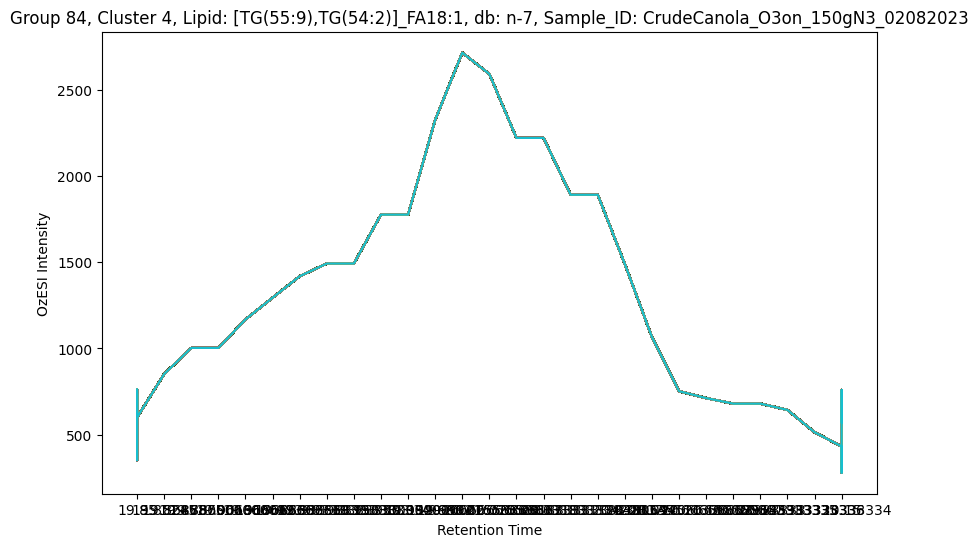

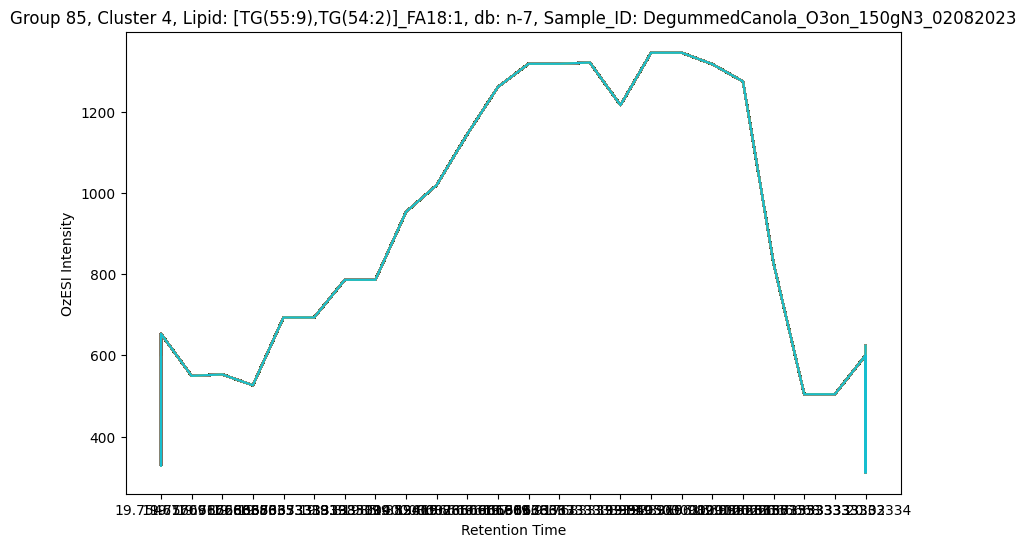

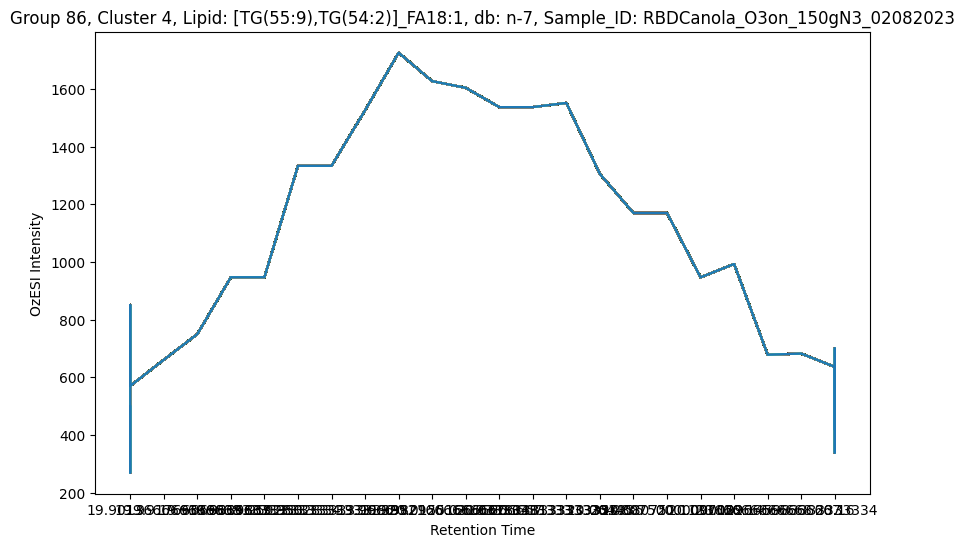

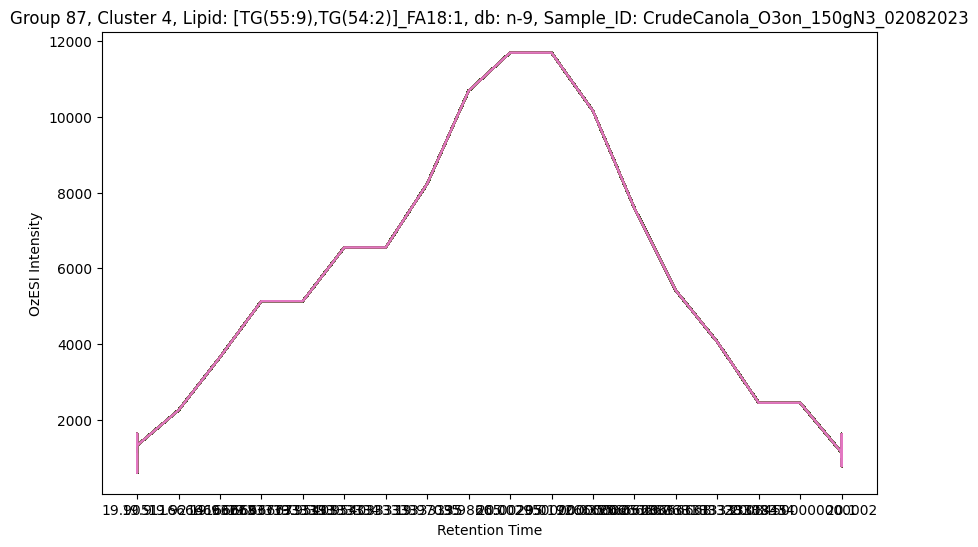

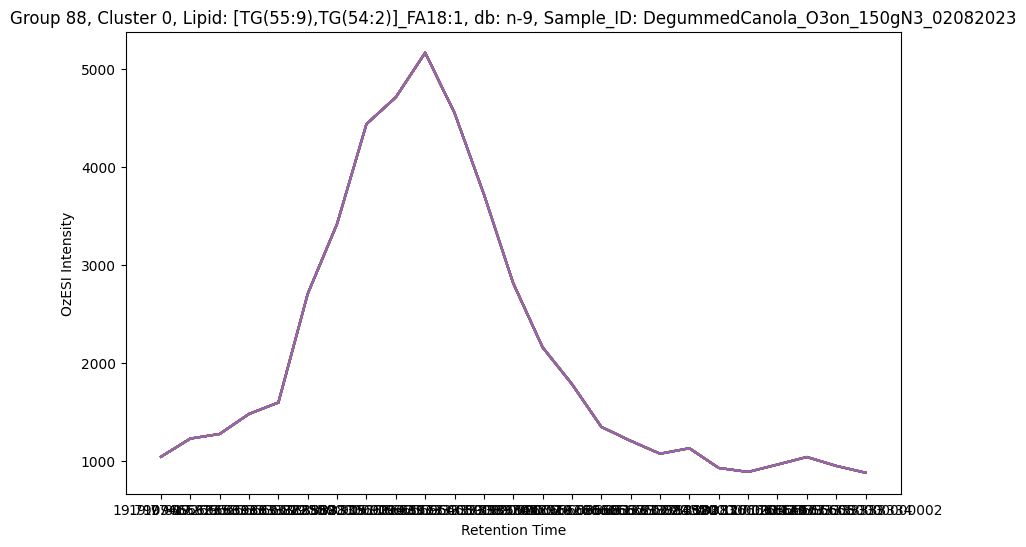

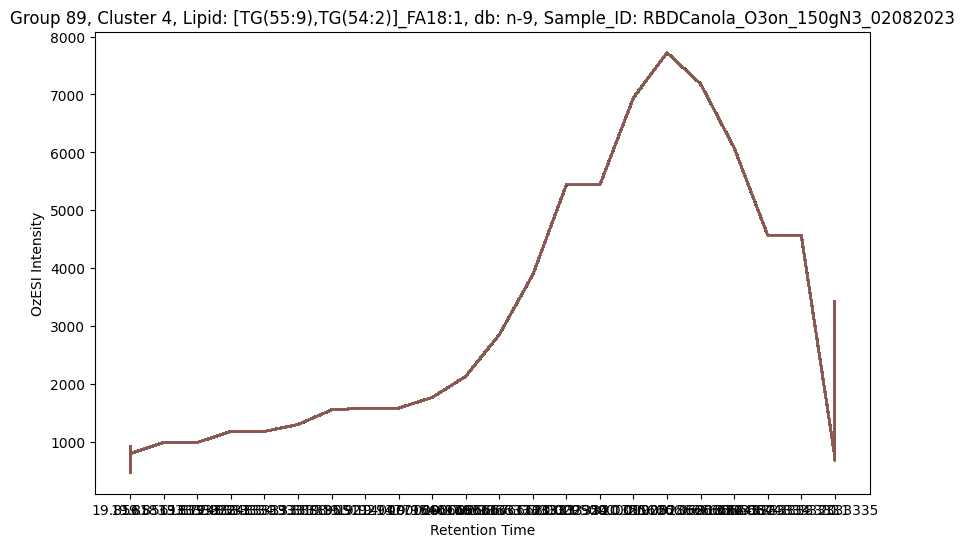

In [493]:
import matplotlib.pyplot as plt
import os

def plot_data(group_data, group, cluster_label, lipid_substring, save_dir):
    # Filter group_data for lipids containing the specified substring, if provided
    if lipid_substring:
        group_data = group_data[group_data['Lipid'].str.contains(lipid_substring)]

    if group_data.empty:
        return

    # Extracting data for plotting
    times = group_data['Retention_Time'].values
    intensities = group_data['OzESI_Intensity'].values

    # Plotting
    plt.figure(figsize=(10, 6))
    for _, row in group_data.iterrows():
        plt.plot(times, intensities, label=f"{row['Lipid']} Intensity")
    plt.xlabel('Retention Time')
    plt.ylabel('OzESI Intensity')

    # Extract additional information for the title
    lipid = group_data.iloc[0]['Lipid']
    db = group_data.iloc[0]['db']
    sample_id = group_data.iloc[0]['Sample_ID']
    plt.title(f'Group {group}, Cluster {cluster_label}, Lipid: {lipid}, db: {db}, Sample_ID: {sample_id}')

    # plt.legend()

    # Save the plot
    filename = f'Group_{group}_Cluster_{cluster_label}_Lipids_containing_{lipid_substring}.png'
    # Uncomment the line below to save the plot
    # plt.savefig(os.path.join(save_dir, filename), bbox_inches='tight')
    plt.show()
    plt.close()

# Define the directory to save the plots
save_directory = 'Projects/canola/plots/peak_check/manual/'  # Replace with your directory path

# Specify the substring to search in the Lipid column
selected_lipid_substring = '54:2'  # Replace with the substring you want to search for

# Plotting for each group-cluster pair in d14
for (group, cluster_label), group_df in d10.groupby(['Group', 'Cluster_Label']):
    plot_data(group_df, group, cluster_label, selected_lipid_substring, save_directory)


# filter again??

In [494]:
# d10a = d10.copy()  # Creating d10a DataFrame from the newly filtered d9

# # Initialize an empty DataFrame to store the filtered results
# filtered_d10 = pd.DataFrame()

# # Iterate over each group-cluster pair
# for (group, cluster_label), group_df in d10a.groupby(['Group', 'Cluster_Label']):
#     # Get the RT_Start and RT_End values for the current group-cluster pair
#     rt_start = group_df['RT_Start'].iloc[0]
#     rt_end = group_df['RT_End'].iloc[0]

#     # Filter the DataFrame for rows where Retention_Time is within the start and end window
#     within_window = group_df[(group_df['Retention_Time'] >= rt_start) & (group_df['Retention_Time'] <= rt_end)]

#     # Append the filtered data to the results DataFrame
#     filtered_d10 = pd.concat([filtered_d10, within_window])

# # Assign the filtered DataFrame back to d10a
# d10a = filtered_d10

# # Display the filtered DataFrame
# d10a


# Calculate Area of peak

In [495]:
d11 = d10.copy()  # Creating d11 DataFrame from the newly filtered d10


### Area using TRAPZ
import pandas as pd
from scipy.integrate import trapz



# Create an empty DataFrame for storing the calculated areas
area_results = pd.DataFrame(columns=['Group', 'Cluster_Label', 'Area'])

# Group by 'Group' and 'Cluster_Label'
grouped_data = d11.groupby(['Group', 'Cluster_Label'])

# Iterate over each group and calculate the area
for (group, cluster_label), group_data in grouped_data:
    # Sort the group data by 'Retention_Time'
    sorted_group_data = group_data.sort_values(by='Retention_Time')

    # Extract 'Retention_Time' and 'OzESI_Intensity'
    retention_time = sorted_group_data['Retention_Time']
    intensity = sorted_group_data['OzESI_Intensity']

    # Calculate the area using the trapezoidal rule
    area = trapz(intensity, retention_time)

    # Append the results to the area_results DataFrame
    area_results = area_results.append({
        'Group': group, 
        'Cluster_Label': cluster_label, 
        'Area': area
    }, ignore_index=True)

# Merge the calculated areas back into the original DataFrame
d11 = pd.merge(d11, area_results, on=['Group', 'Cluster_Label'])

# Round the 'Area' to 0 decimal places
d11['Area'] = d11['Area'].round(0)
d11


TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [ ]:
# Filter the DataFrame based on Lipid and Purity = Crude and db = n-9, and Retention_Time between 19.5 and 20.5
filtered_df = d11[(d11['Lipid'].str.contains('TG\(54:2\)')) & 
                 (d11['Purity'].str.contains('Crude')) & 
                 (d11['db'].str.contains('n-9')) & 
                 (d11['Retention_Time'] >= 19.5) & 
                 (d11['Retention_Time'] <= 20.5)]

# Print the filtered values
filtered_df

,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,db,Lipid,Purity,FAC,TG,Group,Cluster_Label,Max_Intensity,RT_Start,RT_End,Area
1781,794.6,605.6,19.9,1320.160034,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,4,11693.0,19.9,20.1,1265.0
1782,794.6,605.6,19.9,713.660034,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,4,1245.0,19.9,20.1,1265.0
1783,794.6,605.6,19.9,674.020020,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,4,1245.0,19.9,20.1,1265.0
1784,794.6,605.6,19.9,916.180054,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,4,1245.0,19.9,20.1,1265.0
1785,794.6,605.6,19.9,809.420044,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,4,1245.0,19.9,20.1,1265.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1883,794.6,605.6,20.1,836.780029,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,4,1327.0,19.9,20.1,1265.0
1884,794.6,605.6,20.1,774.200073,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,4,1327.0,19.9,20.1,1265.0
1885,794.6,605.6,20.1,795.720032,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,4,1327.0,19.9,20.1,1265.0
1886,794.6,605.6,20.1,1123.880127,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,4,1327.0,19.9,20.1,1265.0


# Check area calc is correct?

In [ ]:
# Assuming d5a is your original DataFrame and is already loaded in your environment

##Single Cluster and Group

# # Specify the Group and Cluster_Label you want to filter
# specific_group = 39  # Replace with the specific group number you want
# specific_cluster_label = 0  # Replace with the specific cluster label you want

# # Create a new DataFrame d5a_check from d5a for specific Group and Cluster_Label
# d5a_check = d5a[(d5a['Group'] == specific_group) & (d5a['Cluster_Label'] == specific_cluster_label)]

# # Display the first few rows of the new DataFrame d5a_check
# d5a_check


# ### All clusters in group
# # Assuming d5a is your original DataFrame and is already loaded in your environment

# # Specify the Group and Cluster_Label you want to filter
# specific_group = 39  # Replace with the specific group number you want

# # Create a new DataFrame d5a_check from d5a for specific Group and Cluster_Label
# d5a_check = d5a[(d5a['Group'] == specific_group)]

# # Display the first few rows of the new DataFrame d5a_check
# d5a_check


# Data Dependent Threshold (List of intensities)

In [ ]:
d12 = d11.copy()

# Group the data by 'Group' and collect the 'OzESI_Intensity' values in lists
grouped_data = d12.groupby('Group')['OzESI_Intensity'].apply(list).reset_index(name='Group_Intensity')
# Merge the original data with the grouped data
d12 = d12.merge(grouped_data, on='Group')


# Sorting the lists in the 'Group_Intensity' column
d12['Group_Intensity'] = d12['Group_Intensity'].apply(lambda x: sorted(x))

d12  # Display the first few rows of the merged DataFrame

import pandas as pd

def set_threshold(group_intensity_list, threshold1=0.3, threshold2=0):
    """
    Function to set a threshold at a specified level of the list and add an additional value to it.

    :param group_intensity_list: List of intensity values for a group.
    :param threshold1: The percentage level at which to set the threshold (default is 0.3 for 30%).
    :param threshold2: An additional value to add to the threshold (default is 0).
    :return: The threshold value.
    """
    if not group_intensity_list:
        return None
    sorted_list = sorted(group_intensity_list)
    index = int(len(sorted_list) * threshold1)
    return sorted_list[index] + threshold2

# Example usage
# Assuming df_merged is your DataFrame with the 'Group_Intensity' column | 1.5 100 decent
d12['Group_Threshold'] = d12['Group_Intensity'].apply(lambda x: set_threshold(x, threshold1=0.15, threshold2=100))
#round the threshold to 0 decimal places
d12['Group_Threshold'] = d12['Group_Threshold'].round(0)


# To display the first few rows of the DataFrame with the new column
d12

# Filter the DataFrame to keep only the rows where 'OzESI_Intensity' is greater than or equal to 'Group_Threshold'
d13 = d12[d12['OzESI_Intensity'] >= d12['Group_Threshold']]

# Display the first few rows of the filtered DataFrame
d13

# Filter the DataFrame based on Lipid and Purity = Crude and db = n-9, and Retention_Time between 19.5 and 20.5
filtered_df = d13[(d13['Lipid'].str.contains('TG\(54:2\)')) & 
                 (d13['Purity'].str.contains('Crude')) & 
                 (d13['db'].str.contains('n-9')) & 
                 (d13['Retention_Time'] >= 19.5) & 
                 (d13['Retention_Time'] <= 20.5)]

# Print the filtered values
filtered_df



,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,db,Lipid,Purity,FAC,TG,Group,Cluster_Label,Max_Intensity,RT_Start,RT_End,Area,Group_Intensity,Group_Threshold
1781,794.6,605.6,19.9,1320.160034,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,4,11693.0,19.9,20.1,1265.0,"[598.300048828125, 613.320068359375, 628.02001...",937.0
1787,794.6,605.6,19.9,1106.740112,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,4,11693.0,19.9,20.1,1265.0,"[598.300048828125, 613.320068359375, 628.02001...",937.0
1788,794.6,605.6,19.9,1130.460083,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,4,11693.0,19.9,20.1,1265.0,"[598.300048828125, 613.320068359375, 628.02001...",937.0
1789,794.6,605.6,19.9,1308.420044,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,4,11693.0,19.9,20.1,1265.0,"[598.300048828125, 613.320068359375, 628.02001...",937.0
1790,794.6,605.6,19.9,1207.040039,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,4,11693.0,19.9,20.1,1265.0,"[598.300048828125, 613.320068359375, 628.02001...",937.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1876,794.6,605.6,20.1,1148.480103,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,4,1327.0,19.9,20.1,1265.0,"[598.300048828125, 613.320068359375, 628.02001...",937.0
1877,794.6,605.6,20.1,1209.160034,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,4,1327.0,19.9,20.1,1265.0,"[598.300048828125, 613.320068359375, 628.02001...",937.0
1878,794.6,605.6,20.1,1057.480103,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,4,1327.0,19.9,20.1,1265.0,"[598.300048828125, 613.320068359375, 628.02001...",937.0
1886,794.6,605.6,20.1,1123.880127,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,4,1327.0,19.9,20.1,1265.0,"[598.300048828125, 613.320068359375, 628.02001...",937.0


In [ ]:
# Assuming d13 is your DataFrame
# d13 = # your DataFrame

# Filter the DataFrame for Group 60
group_60_data = d13[d13['Group'] == 87]

# Check if the Group_Intensity column exists and contains list-like objects
if 'Group_Intensity' in group_60_data.columns and group_60_data['Group_Intensity'].apply(lambda x: isinstance(x, list)).any():
    # Calculate the length of each item in the Group_Intensity list for Group 60
    lengths_group_intensity_60 = group_60_data['Group_Intensity'].apply(len)

    # Print the length just once for Group 60
    if not lengths_group_intensity_60.empty:
        print(f"Length of Group_Intensity list for Group 60: {lengths_group_intensity_60.iloc[0]}")

        # Print the min and max values in the list
        min_value = min(group_60_data['Group_Intensity'].iloc[0])
        max_value = max(group_60_data['Group_Intensity'].iloc[0])
        print(f"Minimum value in Group_Intensity for Group 60: {min_value}")
        print(f"Maximum value in Group_Intensity for Group 60: {max_value}")
    else:
        print("No Group_Intensity data found for Group 60.")
else:
    print("Group_Intensity column not found or does not contain list-like objects.")


Length of Group_Intensity list for Group 60: 107
Minimum value in Group_Intensity for Group 60: 598.300048828125
Maximum value in Group_Intensity for Group 60: 11693.0810546875


In [ ]:
d13[d13['Group'] == 87]
#print min OzESI_Intensity
d13[d13['Group'] == 87]['OzESI_Intensity'].min()

# d12[d12['Group'] == 87]
# # #print min OzESI_Intensity
# d12[d12['Group'] == 87]['OzESI_Intensity'].min()
# # Assuming d12 is your DataFrame
# # d12 = # your DataFrame

# # Filter the DataFrame for Group 87
# group_87_data = d12[d12['Group'] == 87]

# # Find the row with the minimum OzESI_Intensity in Group 87
# min_intensity_row = group_87_data[group_87_data['OzESI_Intensity'] == group_87_data['OzESI_Intensity'].min()]

# # Extract and print the Retention_Time from that row
# if not min_intensity_row.empty:
#     retention_time_at_min_intensity = min_intensity_row['Retention_Time'].iloc[0]
#     print(f"Retention_Time at minimum OzESI_Intensity for Group 87: {retention_time_at_min_intensity}")
# else:
#     print("No data found for Group 87 or unable to determine minimum OzESI_Intensity.")

# # Assuming d12 is your DataFrame
# # d12 = # your DataFrame

# # Filter the DataFrame for Group 87 and Retention_Time 19.9
# group_87_at_retention_time = d12[(d12['Group'] == 87) & (d12['Retention_Time'] == 19.9)]

# # Assuming d12 is your DataFrame
# # d12 = # your DataFrame

# # Filter the DataFrame for Group 87 and Retention_Time 19.9
# group_87_at_retention_time_19_9 = d12[(d12['Group'] == 87) & (d12['Retention_Time'] == 19.9)]

# # Display the new DataFrame
# group_87_at_retention_time_19_9



946.8600463867188

# DDT Area Calculations 

In [ ]:
## TRAPZ
import pandas as pd
from scipy.integrate import trapz

# Assuming d5e is your original DataFrame
d14 = d13.copy()

# Create an empty DataFrame for storing the calculated areas
area_results_ddt = pd.DataFrame(columns=['Group', 'Cluster_Label', 'Area_DDT'])

# Group by 'Group' and 'Cluster_Label'
grouped_data_ddt = d14.groupby(['Group', 'Cluster_Label'])

# Iterate over each group and calculate the area
for (group, cluster_label), group_data in grouped_data_ddt:
    # Sort the group data by 'Retention_Time'
    sorted_group_data = group_data.sort_values(by='Retention_Time')

    # Extract 'Retention_Time' and 'OzESI_Intensity'
    retention_time = sorted_group_data['Retention_Time']
    intensity = sorted_group_data['OzESI_Intensity']

    # Calculate the area using the trapezoidal rule
    area = trapz(intensity, retention_time)

    # Append the results to the area_results_ddt DataFrame
    area_results_ddt = area_results_ddt.append({
        'Group': group, 
        'Cluster_Label': cluster_label, 
        'Area_DDT': area
    }, ignore_index=True)

# ... [previous code for calculating areas and appending to area_results_ddt] ...

# Merge the calculated areas back into the original DataFrame
d14 = pd.merge(d14, area_results_ddt, on=['Group', 'Cluster_Label'], how='left')

# Check if 'Area_DDT' is in d14 after merging
if 'Area_DDT' in d14.columns:
    # Round the 'Area_DDT' to 0 decimal places
    d14['Area_DDT'] = d14['Area_DDT'].round(0)
else:
    print("Area_DDT column not found in d14 after merging.")

# Display the DataFrame
d14






,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,db,Lipid,Purity,FAC,TG,Group,Cluster_Label,Max_Intensity,RT_Start,RT_End,Area,Group_Intensity,Group_Threshold,Area_DDT
0,784.6,595.6,10.157117,232.660019,CrudeCanola_O3on_150gN3_02082023,784.6 -> 595.6,n-9,"[TG(54:7),]_FA18:1",Crude,FA18:1,TG(54:7),60,0,323.0,10.09,10.53,78.0,"[95.40000915527344, 100.90000915527344, 104.12...",207.0,82.0
1,784.6,595.6,10.189733,223.500015,CrudeCanola_O3on_150gN3_02082023,784.6 -> 595.6,n-9,"[TG(54:7),]_FA18:1",Crude,FA18:1,TG(54:7),60,0,323.0,10.09,10.53,78.0,"[95.40000915527344, 100.90000915527344, 104.12...",207.0,82.0
2,784.6,595.6,10.352817,238.780014,CrudeCanola_O3on_150gN3_02082023,784.6 -> 595.6,n-9,"[TG(54:7),]_FA18:1",Crude,FA18:1,TG(54:7),60,0,323.0,10.09,10.53,78.0,"[95.40000915527344, 100.90000915527344, 104.12...",207.0,82.0
3,784.6,595.6,10.369117,277.840027,CrudeCanola_O3on_150gN3_02082023,784.6 -> 595.6,n-9,"[TG(54:7),]_FA18:1",Crude,FA18:1,TG(54:7),60,0,323.0,10.09,10.53,78.0,"[95.40000915527344, 100.90000915527344, 104.12...",207.0,82.0
4,784.6,595.6,10.385433,323.320038,CrudeCanola_O3on_150gN3_02082023,784.6 -> 595.6,n-9,"[TG(54:7),]_FA18:1",Crude,FA18:1,TG(54:7),60,0,323.0,10.09,10.53,78.0,"[95.40000915527344, 100.90000915527344, 104.12...",207.0,82.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1162,794.6,605.6,20.100000,1148.480103,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,4,1327.0,19.90,20.10,1265.0,"[598.300048828125, 613.320068359375, 628.02001...",937.0,1269.0
1163,794.6,605.6,20.100000,1209.160034,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,4,1327.0,19.90,20.10,1265.0,"[598.300048828125, 613.320068359375, 628.02001...",937.0,1269.0
1164,794.6,605.6,20.100000,1057.480103,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,4,1327.0,19.90,20.10,1265.0,"[598.300048828125, 613.320068359375, 628.02001...",937.0,1269.0
1165,794.6,605.6,20.100000,1123.880127,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,4,1327.0,19.90,20.10,1265.0,"[598.300048828125, 613.320068359375, 628.02001...",937.0,1269.0


In [ ]:

# Assuming 'd5' is your pandas DataFrame and contains the necessary columns
d15 = d14.copy()  # Replace d5 with your actual DataFrame



# d15 now has a new column 'Area_HW_DDT' with the area for each subgroup
d15

,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,db,Lipid,Purity,FAC,TG,Group,Cluster_Label,Max_Intensity,RT_Start,RT_End,Area,Group_Intensity,Group_Threshold,Area_DDT
0,784.6,595.6,10.157117,232.660019,CrudeCanola_O3on_150gN3_02082023,784.6 -> 595.6,n-9,"[TG(54:7),]_FA18:1",Crude,FA18:1,TG(54:7),60,0,323.0,10.09,10.53,78.0,"[95.40000915527344, 100.90000915527344, 104.12...",207.0,82.0
1,784.6,595.6,10.189733,223.500015,CrudeCanola_O3on_150gN3_02082023,784.6 -> 595.6,n-9,"[TG(54:7),]_FA18:1",Crude,FA18:1,TG(54:7),60,0,323.0,10.09,10.53,78.0,"[95.40000915527344, 100.90000915527344, 104.12...",207.0,82.0
2,784.6,595.6,10.352817,238.780014,CrudeCanola_O3on_150gN3_02082023,784.6 -> 595.6,n-9,"[TG(54:7),]_FA18:1",Crude,FA18:1,TG(54:7),60,0,323.0,10.09,10.53,78.0,"[95.40000915527344, 100.90000915527344, 104.12...",207.0,82.0
3,784.6,595.6,10.369117,277.840027,CrudeCanola_O3on_150gN3_02082023,784.6 -> 595.6,n-9,"[TG(54:7),]_FA18:1",Crude,FA18:1,TG(54:7),60,0,323.0,10.09,10.53,78.0,"[95.40000915527344, 100.90000915527344, 104.12...",207.0,82.0
4,784.6,595.6,10.385433,323.320038,CrudeCanola_O3on_150gN3_02082023,784.6 -> 595.6,n-9,"[TG(54:7),]_FA18:1",Crude,FA18:1,TG(54:7),60,0,323.0,10.09,10.53,78.0,"[95.40000915527344, 100.90000915527344, 104.12...",207.0,82.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1162,794.6,605.6,20.100000,1148.480103,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,4,1327.0,19.90,20.10,1265.0,"[598.300048828125, 613.320068359375, 628.02001...",937.0,1269.0
1163,794.6,605.6,20.100000,1209.160034,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,4,1327.0,19.90,20.10,1265.0,"[598.300048828125, 613.320068359375, 628.02001...",937.0,1269.0
1164,794.6,605.6,20.100000,1057.480103,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,4,1327.0,19.90,20.10,1265.0,"[598.300048828125, 613.320068359375, 628.02001...",937.0,1269.0
1165,794.6,605.6,20.100000,1123.880127,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,4,1327.0,19.90,20.10,1265.0,"[598.300048828125, 613.320068359375, 628.02001...",937.0,1269.0


In [ ]:
import pandas as pd
d16 = d15.copy()
# # Assuming d5 is your DataFrame
# # First, find the row in each group with the max OzESI_Intensity
# max_intensity_rows = d16.loc[d16.groupby(['Lipid', 'Sample_ID', 'db'])['OzESI_Intensity'].idxmax()]

# # Create a new DataFrame with the necessary columns
# max_rt_df = max_intensity_rows[['Lipid', 'Sample_ID', 'db', 'Retention_Time']]

# # Rename the 'Retention_Time' column to 'Cluster_RT'
# max_rt_df.rename(columns={'Retention_Time': 'Cluster_RT'}, inplace=True)
# #round the retention time to 2 decimal places
# max_rt_df['Cluster_RT'] = max_rt_df['Cluster_RT'].round(2)

# # Merge this back with the original d16 DataFrame
# # This adds the 'Cluster_RT' column to d16, aligning each row with its corresponding retention time for the max intensity
# d16 = pd.merge(d16, max_rt_df, on=['Lipid', 'Sample_ID', 'db'])

# Now d16 will have an additional column 'Cluster_RT' which is the retention time for the max intensity for each Lipid-Cluster for each Sample_ID
d16

# import pandas as pd

# # Assuming d16 is your DataFrame and Lipid is a column in it
# # Filter rows where the Lipid column contains the string "TG(54:2)"
# filtered_rows = d16[d16['Lipid'].str.contains("TG\(52:3\)")]

# # Print the filtered rows from the Lipid column
# filtered_rows

,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,db,Lipid,Purity,FAC,TG,Group,Cluster_Label,Max_Intensity,RT_Start,RT_End,Area,Group_Intensity,Group_Threshold,Area_DDT
0,784.6,595.6,10.157117,232.660019,CrudeCanola_O3on_150gN3_02082023,784.6 -> 595.6,n-9,"[TG(54:7),]_FA18:1",Crude,FA18:1,TG(54:7),60,0,323.0,10.09,10.53,78.0,"[95.40000915527344, 100.90000915527344, 104.12...",207.0,82.0
1,784.6,595.6,10.189733,223.500015,CrudeCanola_O3on_150gN3_02082023,784.6 -> 595.6,n-9,"[TG(54:7),]_FA18:1",Crude,FA18:1,TG(54:7),60,0,323.0,10.09,10.53,78.0,"[95.40000915527344, 100.90000915527344, 104.12...",207.0,82.0
2,784.6,595.6,10.352817,238.780014,CrudeCanola_O3on_150gN3_02082023,784.6 -> 595.6,n-9,"[TG(54:7),]_FA18:1",Crude,FA18:1,TG(54:7),60,0,323.0,10.09,10.53,78.0,"[95.40000915527344, 100.90000915527344, 104.12...",207.0,82.0
3,784.6,595.6,10.369117,277.840027,CrudeCanola_O3on_150gN3_02082023,784.6 -> 595.6,n-9,"[TG(54:7),]_FA18:1",Crude,FA18:1,TG(54:7),60,0,323.0,10.09,10.53,78.0,"[95.40000915527344, 100.90000915527344, 104.12...",207.0,82.0
4,784.6,595.6,10.385433,323.320038,CrudeCanola_O3on_150gN3_02082023,784.6 -> 595.6,n-9,"[TG(54:7),]_FA18:1",Crude,FA18:1,TG(54:7),60,0,323.0,10.09,10.53,78.0,"[95.40000915527344, 100.90000915527344, 104.12...",207.0,82.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1162,794.6,605.6,20.100000,1148.480103,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,4,1327.0,19.90,20.10,1265.0,"[598.300048828125, 613.320068359375, 628.02001...",937.0,1269.0
1163,794.6,605.6,20.100000,1209.160034,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,4,1327.0,19.90,20.10,1265.0,"[598.300048828125, 613.320068359375, 628.02001...",937.0,1269.0
1164,794.6,605.6,20.100000,1057.480103,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,4,1327.0,19.90,20.10,1265.0,"[598.300048828125, 613.320068359375, 628.02001...",937.0,1269.0
1165,794.6,605.6,20.100000,1123.880127,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,4,1327.0,19.90,20.10,1265.0,"[598.300048828125, 613.320068359375, 628.02001...",937.0,1269.0


# compare d5 cluster RT to ground truth RT in df_db_pos

In [ ]:
import pandas as pd
import numpy as np

d17 = d16.copy()
# # Step 1: Create a mapping from Lipid to ground truth Retention_Time in df_db_pos
# ground_truth_rt = dict(zip(df_db_pos['Lipid'], df_db_pos['Retention_Time']))

# # Step 2: Calculate the distance to the ground truth for each row in d17
# d17['distance_to_truth'] = d17.apply(lambda row: abs(row['Retention_Time'] - ground_truth_rt.get(row['Lipid'], np.nan)), axis=1)

# # Filtering out groups with all NaN values in 'distance_to_truth'
# filtered_d18 = d17.dropna(subset=['distance_to_truth'])

# # Step 3: Retain only the cluster closest to the ground truth for each Sample_ID and Lipid
# closest_clusters_idx = filtered_d18.groupby(['Sample_ID', 'Lipid', 'db'])['distance_to_truth'].idxmin()
# closest_clusters = d17.loc[closest_clusters_idx]

# d17 = closest_clusters.copy()
d17


,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,db,Lipid,Purity,FAC,TG,Group,Cluster_Label,Max_Intensity,RT_Start,RT_End,Area,Group_Intensity,Group_Threshold,Area_DDT
0,784.6,595.6,10.157117,232.660019,CrudeCanola_O3on_150gN3_02082023,784.6 -> 595.6,n-9,"[TG(54:7),]_FA18:1",Crude,FA18:1,TG(54:7),60,0,323.0,10.09,10.53,78.0,"[95.40000915527344, 100.90000915527344, 104.12...",207.0,82.0
1,784.6,595.6,10.189733,223.500015,CrudeCanola_O3on_150gN3_02082023,784.6 -> 595.6,n-9,"[TG(54:7),]_FA18:1",Crude,FA18:1,TG(54:7),60,0,323.0,10.09,10.53,78.0,"[95.40000915527344, 100.90000915527344, 104.12...",207.0,82.0
2,784.6,595.6,10.352817,238.780014,CrudeCanola_O3on_150gN3_02082023,784.6 -> 595.6,n-9,"[TG(54:7),]_FA18:1",Crude,FA18:1,TG(54:7),60,0,323.0,10.09,10.53,78.0,"[95.40000915527344, 100.90000915527344, 104.12...",207.0,82.0
3,784.6,595.6,10.369117,277.840027,CrudeCanola_O3on_150gN3_02082023,784.6 -> 595.6,n-9,"[TG(54:7),]_FA18:1",Crude,FA18:1,TG(54:7),60,0,323.0,10.09,10.53,78.0,"[95.40000915527344, 100.90000915527344, 104.12...",207.0,82.0
4,784.6,595.6,10.385433,323.320038,CrudeCanola_O3on_150gN3_02082023,784.6 -> 595.6,n-9,"[TG(54:7),]_FA18:1",Crude,FA18:1,TG(54:7),60,0,323.0,10.09,10.53,78.0,"[95.40000915527344, 100.90000915527344, 104.12...",207.0,82.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1162,794.6,605.6,20.100000,1148.480103,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,4,1327.0,19.90,20.10,1265.0,"[598.300048828125, 613.320068359375, 628.02001...",937.0,1269.0
1163,794.6,605.6,20.100000,1209.160034,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,4,1327.0,19.90,20.10,1265.0,"[598.300048828125, 613.320068359375, 628.02001...",937.0,1269.0
1164,794.6,605.6,20.100000,1057.480103,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,4,1327.0,19.90,20.10,1265.0,"[598.300048828125, 613.320068359375, 628.02001...",937.0,1269.0
1165,794.6,605.6,20.100000,1123.880127,CrudeCanola_O3on_150gN3_02082023,794.6 -> 605.6,n-9,"[TG(55:9),TG(54:2)]_FA18:1",Crude,FA18:1,"TG(54:2), TG(55:9)",87,4,1327.0,19.90,20.10,1265.0,"[598.300048828125, 613.320068359375, 628.02001...",937.0,1269.0


In [ ]:
# # Assuming d5a is your actual DataFrame and contains Groups 4 and 27

# # Extract the 'Area' for Group 4
# area_group_4 = d5f[d5f['Group'] == 4]['Area_DDT'].iloc[0] if not d5f[d5f['Group'] == 4].empty else "Group 4 not found"

# # Extract the 'Area_DDT' for Group 27
# area_group_27 = d5f[d5f['Group'] == 28]['Area_DDT'].iloc[0] if not d5f[d5f['Group'] == 28].empty else "Group 27 not found"

# print("Area_DDT for Group 4:", area_group_4)
# print("Area_DDT for Group 28:", area_group_27)


# Remove clusters not being used

In [ ]:
#based on sample_ID Lipid and db pos, keep the unique value with the highest intensity
# Sort the DataFrame by 'OzESI_Intensity' in descending order to ensure the highest intensity is first

d19 = d17.copy()
# Assuming your DataFrame is named d19
d19 = d19[d19['db'] != '']
d19




#sort d19 by max OzESI_Intensity
d19 = d19.sort_values(by='OzESI_Intensity', ascending=False)

d19 = d19.groupby(['Purity','Lipid', 'Sample_ID', 'db']).first().reset_index()



#round the retention time to 2 decimal places
d19['Retention_Time'] = d19['Retention_Time'].round(2)
#round intensity to 0 decimal places
d19['OzESI_Intensity'] = d19['OzESI_Intensity'].round(0)
d19 = d19.sort_values(by=['Purity','FAC', 'TG'])

d19
#print len Group_Intensity for d19 Group 87
# Assuming d19 is your DataFrame
# d19 = # your DataFrame

# Assuming d19 is your DataFrame
# d19 = # your DataFrame

# Filter the DataFrame for Group 87
group_87_data = d19[d19['Group'] == 87]

# Assuming Group_Intensity is a column containing lists
# Calculate the length of each item in the Group_Intensity list for Group 87
lengths_group_intensity_87 = group_87_data['Group_Intensity'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Print the lengths
for index, length in enumerate(lengths_group_intensity_87, start=1):
    print(f"Length of item {index} in Group_Intensity for Group 87: {length}")



Length of item 1 in Group_Intensity for Group 87: 107


Calculate Area Ratio

In [ ]:
# import pandas as pd

# # Filter for 'n-9' and 'n-7' in the 'db' column
# filtered_df = d6[d6['db'].isin(['n-9', 'n-7'])]

# # Group by 'Lipid' and 'Sample_ID'
# grouped = filtered_df.groupby(['Lipid', 'Sample_ID'])

# # DataFrame for Area Ratios
# area_ratios = pd.DataFrame(columns=['Lipid', 'Sample_ID', 'Area_Ratio'])

# # Calculate Area Ratio for each group
# for (lipid, sample_id), group in grouped:
#     n9_area = group[group['db'] == 'n-9']['Area'].sum()  # Sum if there are multiple 'n-9' entries
#     n7_area = group[group['db'] == 'n-7']['Area'].sum()  # Sum if there are multiple 'n-7' entries
#     ratio = round(n9_area / n7_area, 2) if n7_area != 0 else None

#     # Append to DataFrame
#     area_ratios = area_ratios.append({
#         'Lipid': lipid,
#         'Sample_ID': sample_id,
#         'Area_Ratio': ratio
#     }, ignore_index=True)

# # Merge the Area Ratio DataFrame with the original DataFrame
# d7 = pd.merge(d6, area_ratios, on=['Lipid', 'Sample_ID'], how='left')

# d7.head(50)  # Display the updated DataFrame with 'Area_Ratio'


# calculte area Ratio for one

In [ ]:


# import pandas as pd

# # Assume d6 is your original DataFrame

# # Filter for 'n-9' and 'n-7' in the 'db' column
# filtered_df = d6[d6['db'].isin(['n-9', 'n-7'])]

# # Group by 'Lipid' and 'Sample_ID'
# grouped = filtered_df.groupby(['Lipid', 'Sample_ID'])

# # Initialize Area_Ratio column in the original DataFrame
# d6['Area_Ratio_DDT'] = None

# # Calculate Area Ratio for each group and update the original DataFrame
# for (lipid, sample_id), group in grouped:
#     if 'n-9' in group['db'].values and 'n-7' in group['db'].values:
#         n9_area = group[group['db'] == 'n-9']['Area_DDT'].sum()
#         n7_area = group[group['db'] == 'n-7']['Area_DDT'].sum()
#         ratio = round(n9_area / n7_area, 2) if n7_area != 0 else None

#         # Update only relevant rows in the original DataFrame
#         indices = d6[(d6['Lipid'] == lipid) & (d6['Sample_ID'] == sample_id) & (d6['db'].isin(['n-9', 'n-7']))].index
#         d6.loc[indices, 'Area_Ratio_DDT'] = ratio



# # Now d6 should have the correctly assigned Area_Ratio
# d6  # Display the updated DataFrame


# Calculate Area for all 4

In [ ]:
d20 = d19.copy()

# Filter for 'n-9' and 'n-7' in the 'db' column
filtered_df = d20[d20['db'].isin(['n-9', 'n-7'])]

# Group by 'Lipid' and 'Sample_ID'
grouped = filtered_df.groupby(['Lipid', 'Sample_ID'])

# Initialize the Ratio columns in the original DataFrame
d20['Area_Ratio'] = None
d20['Area_DDT_Ratio'] = None


# Calculate Ratios for each group and update the original DataFrame
for (lipid, sample_id), group in grouped:
    if 'n-9' in group['db'].values and 'n-7' in group['db'].values:
        # Calculate Area Ratio
        n9_area = group[group['db'] == 'n-9']['Area'].sum()
        n7_area = group[group['db'] == 'n-7']['Area'].sum()
        area_ratio = n9_area / n7_area if n7_area != 0 else None

        # Calculate Area_DDT Ratio
        n9_area_ddt = group[group['db'] == 'n-9']['Area_DDT'].sum()
        n7_area_ddt = group[group['db'] == 'n-7']['Area_DDT'].sum()
        area_ddt_ratio = n9_area_ddt / n7_area_ddt if n7_area_ddt != 0 else None


        # Update the original DataFrame
        indices = d20[(d20['Lipid'] == lipid) & (d20['Sample_ID'] == sample_id)].index
        d20.loc[indices, 'Area_Ratio'] = area_ratio
        d20.loc[indices, 'Area_DDT_Ratio'] = area_ddt_ratio


# The d20 DataFrame now has the new columns for the calculated ratios
# d20  # Display the first few rows of the updated DataFrame


FAC and TG sorting

In [ ]:
import pandas as pd
d21 = d20.copy()
d21

# # Assume d21 is your DataFrame

# # Function to determine the value for the FAC column
# def determine_fac(lipid):
#     if 'FA18:1' in lipid:
#         return 'FA18:1'
#     elif 'FA16:1' in lipid:
#         return 'FA16:1'
#     else:
#         return None  # or some other default value

# # Apply the function to the Lipid column to create the FAC column
# d21['FAC'] = d21['Lipid'].apply(determine_fac)

# import pandas as pd
# import re

# # Function to extract TG values
# def extract_tg(lipid):
#     # Regular expression pattern to match TG(##:#) or similar patterns
#     pattern = r'TG\(\d+:\d+\)'
#     matches = re.findall(pattern, lipid)
#     return ', '.join(matches) if matches else None

# # Apply the function to the Lipid column to create the TG column
# d21['TG'] = d21['Lipid'].apply(extract_tg)




# # Function to sort TG values within a cell
# def sort_tg_values(tg_cell):
#     if not pd.isna(tg_cell) and ', ' in tg_cell:
#         tg_list = tg_cell.split(', ')
#         tg_list_sorted = sorted(tg_list, key=lambda x: [int(i) for i in x[3:-1].split(':')])
#         return ', '.join(tg_list_sorted)
#     else:
#         return tg_cell

# # Apply the function to the TG column
# d21['TG'] = d21['TG'].apply(sort_tg_values)
# d21 = d21.sort_values(by=['FAC', 'TG'])

# # Display the DataFrame
# d21


,Purity,Lipid,Sample_ID,db,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Transition,FAC,...,Cluster_Label,Max_Intensity,RT_Start,RT_End,Area,Group_Intensity,Group_Threshold,Area_DDT,Area_Ratio,Area_DDT_Ratio
6,Crude,"[TG(53:9),TG(52:2)]_FA18:1",CrudeCanola_O3on_150gN3_02082023,n-7,794.7,577.6,18.05,3815.0,794.7 -> 577.6,FA18:1,...,0,3815.0,17.80,18.22,671.0,"[570.7200317382812, 632.280029296875, 633.5400...",756.0,593.0,3.166915,3.524452
7,Crude,"[TG(53:9),TG(52:2)]_FA18:1",CrudeCanola_O3on_150gN3_02082023,n-9,766.7,577.6,18.05,16153.0,766.7 -> 577.6,FA18:1,...,0,16153.0,17.82,18.25,2125.0,"[942.2400512695312, 999.820068359375, 1033.760...",1275.0,2090.0,3.166915,3.524452
4,Crude,"[TG(53:10),TG(52:3)]_FA18:1",CrudeCanola_O3on_150gN3_02082023,n-7,792.7,575.6,16.04,1083.0,792.7 -> 575.6,FA18:1,...,0,1083.0,15.89,16.30,269.0,"[314.780029296875, 347.22003173828125, 367.560...",472.0,229.0,2.189591,2.091703
5,Crude,"[TG(53:10),TG(52:3)]_FA18:1",CrudeCanola_O3on_150gN3_02082023,n-9,764.6,575.6,16.09,3420.0,764.6 -> 575.6,FA18:1,...,2,3420.0,15.92,16.32,589.0,"[730.1400756835938, 776.7000732421875, 793.440...",897.0,479.0,2.189591,2.091703
0,Crude,[TG(52:4)]_FA18:1,CrudeCanola_O3on_150gN3_02082023,n-7,790.7,573.6,14.31,615.0,790.7 -> 573.6,FA18:1,...,0,615.0,14.12,14.54,158.0,"[96.58000946044922, 168.04000854492188, 214.40...",328.0,107.0,2.075949,2.626168
1,Crude,[TG(52:4)]_FA18:1,CrudeCanola_O3on_150gN3_02082023,n-9,762.6,573.6,14.30,1875.0,762.6 -> 573.6,FA18:1,...,2,1875.0,14.14,14.55,328.0,"[274.08001708984375, 288.5000305175781, 294.36...",401.0,281.0,2.075949,2.626168
2,Crude,[TG(52:5)]_FA18:1,CrudeCanola_O3on_150gN3_02082023,n-7,788.6,571.6,12.41,333.0,788.6 -> 571.6,FA18:1,...,1,333.0,12.36,12.78,74.0,"[86.7800064086914, 107.30001068115234, 113.900...",222.0,49.0,1.216216,2.244898
3,Crude,[TG(52:5)]_FA18:1,CrudeCanola_O3on_150gN3_02082023,n-9,760.6,571.6,12.43,570.0,760.6 -> 571.6,FA18:1,...,2,579.0,12.41,12.82,90.0,"[84.74000549316406, 108.46000671386719, 125.62...",253.0,110.0,1.216216,2.244898
18,Crude,"[TG(55:9),TG(54:2)]_FA18:1",CrudeCanola_O3on_150gN3_02082023,n-7,822.7,605.6,19.98,2716.0,822.7 -> 605.6,FA18:1,...,4,2716.0,19.85,20.15,426.0,"[278.4200134277344, 301.7400207519531, 351.540...",581.0,429.0,2.969484,2.958042
19,Crude,"[TG(55:9),TG(54:2)]_FA18:1",CrudeCanola_O3on_150gN3_02082023,n-9,794.6,605.6,20.00,11693.0,794.6 -> 605.6,FA18:1,...,4,11693.0,19.90,20.10,1265.0,"[598.300048828125, 613.320068359375, 628.02001...",937.0,1269.0,2.969484,2.958042


In [ ]:
# import pandas as pd

# # Assuming d6 and df_db_pos are your DataFrames and user_window is the time window specified by the user
# user_window = 0.2  # Replace 0.5 with the value specified by the user

# # Copy d6 to d22
# d22 = d21.copy()

# # Iterate over each row in d22
# for index, row in d22.iterrows():
#     # Extract Lipid and Retention_Time from the row in d22
#     lipid = row['Lipid']
#     retention_time_d7 = row['Retention_Time']

#     # Find the corresponding row in df_db_pos
#     df_db_pos_row = df_db_pos[df_db_pos['Lipid'] == lipid]

#     # Check if the lipid was found in df_db_pos
#     if not df_db_pos_row.empty:
#         # Extract the Average_Retention_Time from df_db_pos
#         retention_time_db_pos = df_db_pos_row.iloc[0]['Retention_Time']

#         # Check if the retention time in d22 is outside the specified window
#         if abs(retention_time_d7 - retention_time_db_pos) > user_window:
#             # Remove the row from d22 if it is outside the window
#             d22.drop(index, inplace=True)

# # #show all TG(52:5)
# # d22[d22['Lipid'].str.contains('TG\(54:3\)')].head(60)


# # d22

# # # Filter for rows where 'Lipid' contains 'TG(52:5)' and FA16:1
# # filtered_rows = d22[(d22['Lipid'].str.contains('TG\(54:2\)')) ]

# # filtered_rows

Remove extra TG so can compare vs caitlin data

In [ ]:

# Make a copy of the DataFrame
d23 = d21.copy()

def remove_first_tg(lipid):
    tg_parts = lipid.split(',')
    # Check if there are at least two parts and the second part contains 'TG'
    if len(tg_parts) > 1 and 'TG' in tg_parts[1]:
        return '[' + tg_parts[1]
    else:
        return lipid

# Apply the function to the Lipid column
d23['Lipid'] = d23['Lipid'].apply(remove_first_tg)

# Sorting by 'Purity' and then by 'Lipid'
d23 = d23.sort_values(by=['Purity', 'Lipid'])



d23.to_excel('Projects/canola/CLAW_data/Area_data/CLAW_Canola_Area_dataframe_05Jan24_v2.xlsx')
# d23.to_csv('Projects/canola/CLAW_data/Area_data/CLAW_Canola_Area_dataframe_05Jan24_v2.csv')
d23

,Purity,Lipid,Sample_ID,db,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Transition,FAC,...,Cluster_Label,Max_Intensity,RT_Start,RT_End,Area,Group_Intensity,Group_Threshold,Area_DDT,Area_Ratio,Area_DDT_Ratio
6,Crude,[TG(52:2)]_FA18:1,CrudeCanola_O3on_150gN3_02082023,n-7,794.7,577.6,18.05,3815.0,794.7 -> 577.6,FA18:1,...,0,3815.0,17.80,18.22,671.0,"[570.7200317382812, 632.280029296875, 633.5400...",756.0,593.0,3.166915,3.524452
7,Crude,[TG(52:2)]_FA18:1,CrudeCanola_O3on_150gN3_02082023,n-9,766.7,577.6,18.05,16153.0,766.7 -> 577.6,FA18:1,...,0,16153.0,17.82,18.25,2125.0,"[942.2400512695312, 999.820068359375, 1033.760...",1275.0,2090.0,3.166915,3.524452
4,Crude,[TG(52:3)]_FA18:1,CrudeCanola_O3on_150gN3_02082023,n-7,792.7,575.6,16.04,1083.0,792.7 -> 575.6,FA18:1,...,0,1083.0,15.89,16.30,269.0,"[314.780029296875, 347.22003173828125, 367.560...",472.0,229.0,2.189591,2.091703
5,Crude,[TG(52:3)]_FA18:1,CrudeCanola_O3on_150gN3_02082023,n-9,764.6,575.6,16.09,3420.0,764.6 -> 575.6,FA18:1,...,2,3420.0,15.92,16.32,589.0,"[730.1400756835938, 776.7000732421875, 793.440...",897.0,479.0,2.189591,2.091703
0,Crude,[TG(52:4)]_FA18:1,CrudeCanola_O3on_150gN3_02082023,n-7,790.7,573.6,14.31,615.0,790.7 -> 573.6,FA18:1,...,0,615.0,14.12,14.54,158.0,"[96.58000946044922, 168.04000854492188, 214.40...",328.0,107.0,2.075949,2.626168
1,Crude,[TG(52:4)]_FA18:1,CrudeCanola_O3on_150gN3_02082023,n-9,762.6,573.6,14.30,1875.0,762.6 -> 573.6,FA18:1,...,2,1875.0,14.14,14.55,328.0,"[274.08001708984375, 288.5000305175781, 294.36...",401.0,281.0,2.075949,2.626168
2,Crude,[TG(52:5)]_FA18:1,CrudeCanola_O3on_150gN3_02082023,n-7,788.6,571.6,12.41,333.0,788.6 -> 571.6,FA18:1,...,1,333.0,12.36,12.78,74.0,"[86.7800064086914, 107.30001068115234, 113.900...",222.0,49.0,1.216216,2.244898
3,Crude,[TG(52:5)]_FA18:1,CrudeCanola_O3on_150gN3_02082023,n-9,760.6,571.6,12.43,570.0,760.6 -> 571.6,FA18:1,...,2,579.0,12.41,12.82,90.0,"[84.74000549316406, 108.46000671386719, 125.62...",253.0,110.0,1.216216,2.244898
18,Crude,[TG(54:2)]_FA18:1,CrudeCanola_O3on_150gN3_02082023,n-7,822.7,605.6,19.98,2716.0,822.7 -> 605.6,FA18:1,...,4,2716.0,19.85,20.15,426.0,"[278.4200134277344, 301.7400207519531, 351.540...",581.0,429.0,2.969484,2.958042
19,Crude,[TG(54:2)]_FA18:1,CrudeCanola_O3on_150gN3_02082023,n-9,794.6,605.6,20.00,11693.0,794.6 -> 605.6,FA18:1,...,4,11693.0,19.90,20.10,1265.0,"[598.300048828125, 613.320068359375, 628.02001...",937.0,1269.0,2.969484,2.958042


# Clean up d23 and save to excel

In [ ]:
d23_excel = d23.copy()
# Assuming d23 is your DataFrame
d23_excel = d23_excel.drop(columns=['Area_Ratio', 'Group_Intensity', 'Cluster_Label','Area_DDT','Area_DDT_Ratio','Area','Group_Threshold','RT_Start','RT_End','TG'])
# Filter out rows where 'Lipid' column contains any of the specified strings
d23_excel = d23_excel[~d23_excel['Lipid'].str.contains('TG\(52:5\)|TG\(54:7\)|TG\(54:6\)')]

d23_excel.to_excel('Projects/canola/CLAW_data/dataframe/CLAW_Canola_Area_d24dataframe_07Jan24_v2_excel.xlsx')
d23_excel


,Purity,Lipid,Sample_ID,db,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Transition,FAC,Group,Max_Intensity
6,Crude,[TG(52:2)]_FA18:1,CrudeCanola_O3on_150gN3_02082023,n-7,794.7,577.6,18.05,3815.0,794.7 -> 577.6,FA18:1,30,3815.0
7,Crude,[TG(52:2)]_FA18:1,CrudeCanola_O3on_150gN3_02082023,n-9,766.7,577.6,18.05,16153.0,766.7 -> 577.6,FA18:1,33,16153.0
4,Crude,[TG(52:3)]_FA18:1,CrudeCanola_O3on_150gN3_02082023,n-7,792.7,575.6,16.04,1083.0,792.7 -> 575.6,FA18:1,21,1083.0
5,Crude,[TG(52:3)]_FA18:1,CrudeCanola_O3on_150gN3_02082023,n-9,764.6,575.6,16.09,3420.0,764.6 -> 575.6,FA18:1,24,3420.0
0,Crude,[TG(52:4)]_FA18:1,CrudeCanola_O3on_150gN3_02082023,n-7,790.7,573.6,14.31,615.0,790.7 -> 573.6,FA18:1,3,615.0
1,Crude,[TG(52:4)]_FA18:1,CrudeCanola_O3on_150gN3_02082023,n-9,762.6,573.6,14.30,1875.0,762.6 -> 573.6,FA18:1,6,1875.0
18,Crude,[TG(54:2)]_FA18:1,CrudeCanola_O3on_150gN3_02082023,n-7,822.7,605.6,19.98,2716.0,822.7 -> 605.6,FA18:1,84,2716.0
19,Crude,[TG(54:2)]_FA18:1,CrudeCanola_O3on_150gN3_02082023,n-9,794.6,605.6,20.00,11693.0,794.6 -> 605.6,FA18:1,87,11693.0
14,Crude,[TG(54:3)]_FA18:1,CrudeCanola_O3on_150gN3_02082023,n-7,820.7,603.6,17.98,17186.0,820.7 -> 603.6,FA18:1,66,17186.0
15,Crude,[TG(54:3)]_FA18:1,CrudeCanola_O3on_150gN3_02082023,n-9,792.6,603.6,17.98,99860.0,792.6 -> 603.6,FA18:1,69,99860.0


# Save Results in csv

In [ ]:
# save_results_directory = 'Projects/canola/results/'
# save_results_name = 'CLAW_CanolaOil_Results_05Jan2024'
# file_extension = '.csv'
# file_number = 1
# full_path = os.path.join(save_results_directory, f'{save_results_name}{file_extension}')

# # Check if file exists and increment the number suffix until an unused filename is found
# while os.path.exists(full_path):
#     full_path = os.path.join(save_results_directory, f'{save_results_name}_{file_number}{file_extension}')
#     file_number += 1

# # Save the dataframe to the new path
# d23.to_csv(full_path, index=False)
d23.to_excel('Projects/canola/results/CLAW_Canola_Compare_Results_17Jan24.xlsx')


In [ ]:
# # Extract the necessary columns (modify as per your actual data structure)
# extracted_data = d8[['Lipid', 'Retention_Time', 'Sample_ID']]

# # Step 2: Grouping and Aggregating
# # Here you'll need to group by 'Lipid' and 'Retention_Time' and then calculate the values for each type
# # Example calculation (modify this as per your actual calculation logic)
# grouped_data = extracted_data.groupby(['Lipid', 'Retention_Time']).apply(your_calculation_function)

# # Step 3: Reformatting into the compact form
# # Convert the grouped data into the desired format
# compact_df = grouped_data.unstack()

# # The 'compact_df' now should have a structure similar to your desired compact DataFrame
# # You may need to rename columns or adjust the DataFrame further to match your exact format

# # Display the compact DataFrame
# compact_df

Purity for Canola Oil

In [ ]:
# import matplotlib.pyplot as plt
# import os

# # Assuming d6 is your DataFrame
# # List of lipids to exclude
# excluded_lipids = ['[TG(54:6)]_FA18:1', '[TG(54:7),TG(53:0)]_FA18:1']

# # Get unique Sample_ID values
# unique_sample_ids = d6['Sample_ID'].unique()

# # Loop through each Sample_ID and create a separate plot
# for sample_id in unique_sample_ids:
#     # Filter the DataFrame for the current Sample_ID
#     df_filtered = d6[d6['Sample_ID'] == sample_id]

#     # Exclude specific lipids
#     df_filtered = df_filtered[~df_filtered['Lipid'].isin(excluded_lipids)]

#     # Removing rows where Ratio is NaN or 0
#     df_filtered = df_filtered[df_filtered['Area_Ratio'].notna() & (df_filtered['Area_Ratio'] != 0)]

#     # Skip plotting if there are no valid data points left after filtering
#     if df_filtered.empty:
#         continue

#     # Setting up the plot
#     plt.figure(figsize=(15, 6))  # Adjust the figure size as needed

#     # Plotting with larger dots
#     plt.plot(df_filtered['Lipid'], df_filtered['Area_Ratio'], color='blue', marker='o', linestyle='-', markersize=12)

#     # Adding labels and title
#     plt.xlabel('Lipid')
#     plt.ylabel('Area Ratio')
#     plt.title(f'Area Ratio for Sample ID: {sample_id}')
#     plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

#     # Set y-axis bottom range to 0
#     plt.ylim(bottom=0)
#     plt.ylim(top=6)

#     # # Save plot
#     # # Uncomment and adjust the directory as needed
#     # plt.savefig(os.path.join(save_dir, f'Area Ratio for Sample ID - {sample_id}.png'), bbox_inches='tight')

#     plt.tight_layout()
#     plt.show()
#     plt.close()  # Close the plot to free up memory


In [ ]:
sanjay = pd.read_csv('Projects/canola/data/Sanjay_manual.csv')
sanjay

,Lipid,RT (min),Crude n-9/n-7,Degummed n-9/n-7,RBD n-9/n-7
0,[TG(52:2)]_FA18:1,18.05,3.92,3.76,4.13
1,[TG(52:3)]_FA18:1,16.30,2.20,3.25,2.34
2,[TG(52:4)]_FA18:1,14.31,2.31,2.25,2.18
3,[TG(54:2)]_FA18:1,20.00,4.27,3.03,4.36
4,[TG(54:3)]_FA18:1,18.00,4.88,4.94,4.57
5,[TG(54:4)]_FA18:1,16.00,3.78,4.06,4.04
6,[TG(54:5)]_FA18:1,14.00,5.58,5.65,4.45


In [ ]:
# d8

# Plot just 1 Area

In [ ]:
# d24 = d23.copy()
# #delete TG(50:3) and TG(52:5) and TG(54:6) and TG 54:5
# d24 = d24[~d24['Lipid'].str.contains('TG\(53:0\)')]
# d24 = d24[~d24['Lipid'].str.contains('TG\(52:5\)')]
# d24 = d24[~d24['Lipid'].str.contains('TG\(54:6\)')]
# # d24 = d24[~d24['Lipid'].str.contains('TG\(54:5\)')]
# # sanjay = sanjay[~sanjay['Lipid'].str.contains('TG\(54:5\)')]


# # Function to create a combined scatter plot
# def create_combined_scatter_plot(df1, df2, x_column_df1, y_column_df1, x_column_df2, y_column_df2, title):
#     plt.figure(figsize=(10, 6))
#     plt.scatter(df1[x_column_df1], df1[y_column_df1], label='Manual Data', marker='s')
#     plt.scatter(df2[x_column_df2], df2[y_column_df2], label='CLAW Data')
#     plt.xlabel('Lipid')
#     plt.ylabel('Ratio')
#     plt.title(title)
#     plt.xticks(rotation=45)
#     plt.legend()
#     plt.tight_layout()
#     plt.show()

# # Filter d8 DataFrame for each category
# df_crude_d9 = d24[d24['Purity'] == 'Crude']
# df_degummed_d9 = d24[d24['Purity'] == 'Degummed']
# df_rbd_d9 = d24[d24['Purity'] == 'RBD']

# # Plotting combined scatter plots for Crude, Degummed, and RBD
# create_combined_scatter_plot(sanjay, df_crude_d9, 'Lipid', 'Crude n-9/n-7', 'Lipid', 'Area_Ratio', 'Crude: Lipid vs Ratio')
# create_combined_scatter_plot(sanjay, df_degummed_d9, 'Lipid', 'Degummed n-9/n-7', 'Lipid', 'Area_Ratio', 'Degummed: Lipid vs Ratio')
# create_combined_scatter_plot(sanjay, df_rbd_d9, 'Lipid', 'RBD n-9/n-7', 'Lipid', 'Area_Ratio', 'RBD: Lipid vs Ratio')


# Plot all the areas

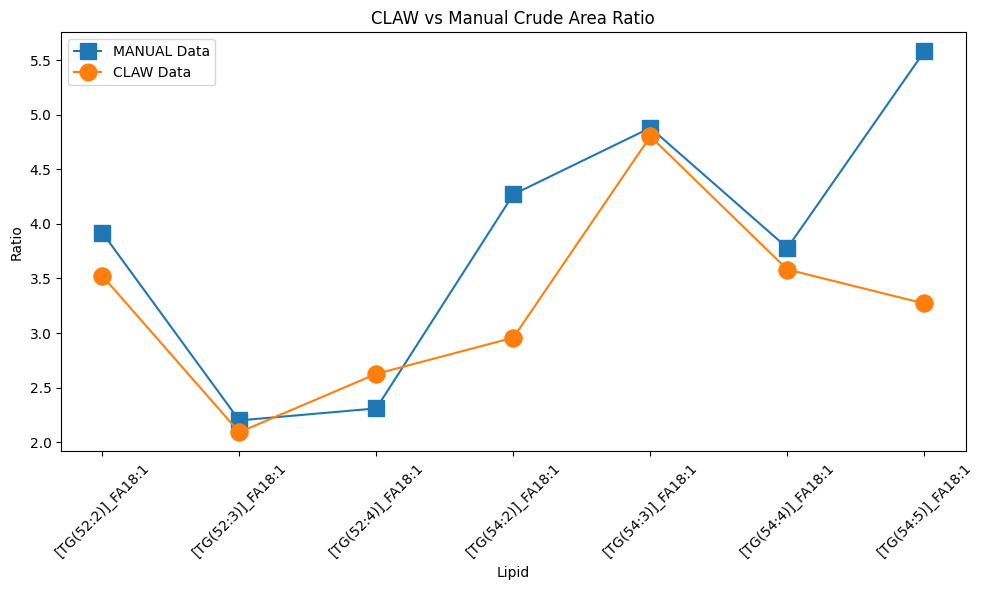

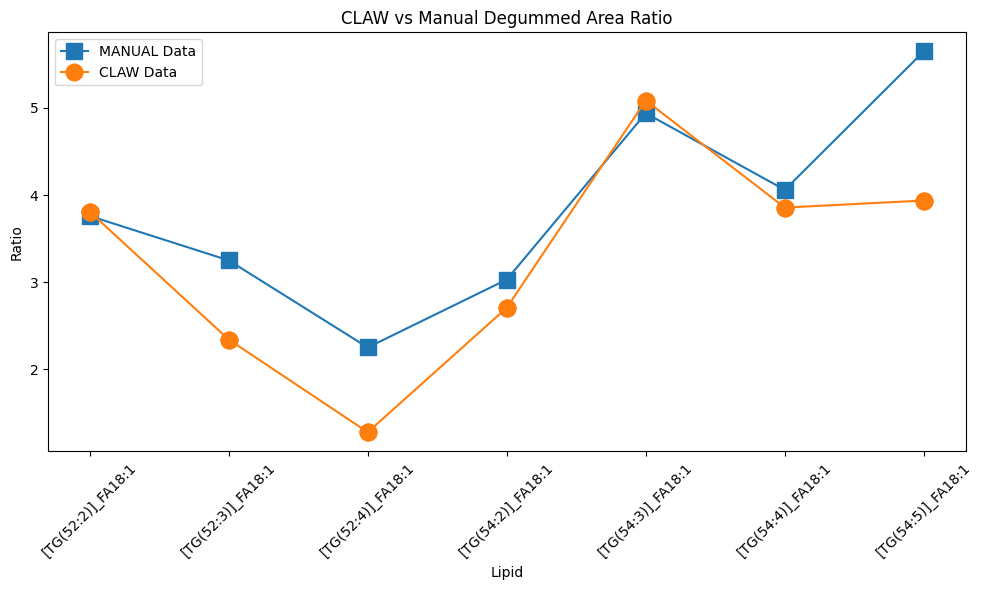

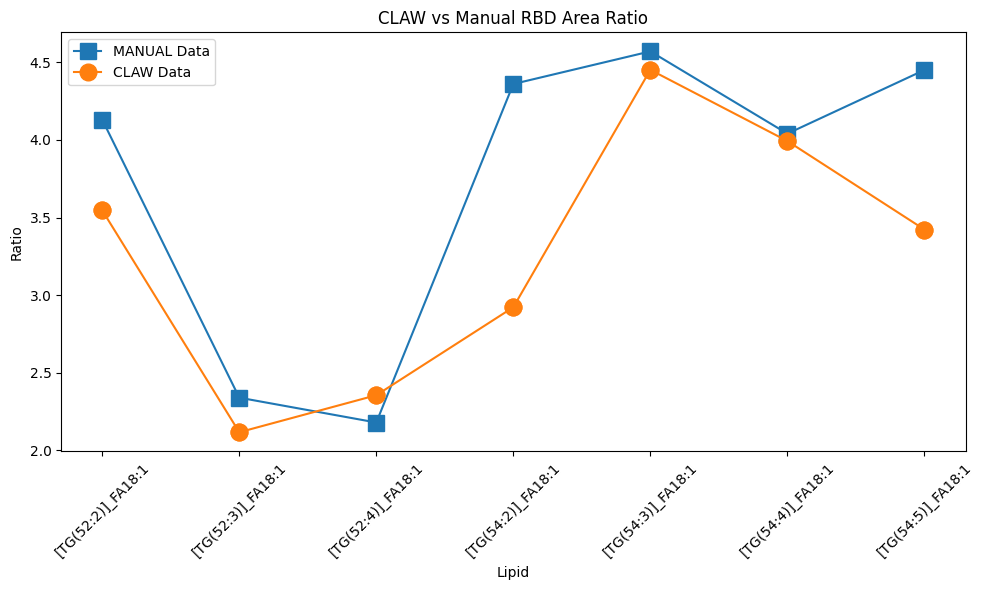

In [ ]:
d24 = d23.copy()
#delete TG(50:3) and TG(52:5) and TG(54:6) and TG 54:5
d24 = d24[~d24['Lipid'].str.contains('TG\(53:0\)')]
d24 = d24[~d24['Lipid'].str.contains('TG\(52:5\)')]
d24 = d24[~d24['Lipid'].str.contains('TG\(54:6\)')]
d24 = d24[~d24['Lipid'].str.contains('TG\(54:7\)')]

d24_directory = 'Projects/canola/CLAW_data/Area_data/'
d24.to_csv(d24_directory + 'CLAW_Canola_AreaPlots_05Jan24.csv', index=False)
save_results_directory = 'Projects/canola/results/'
save_results_name = 'CLAW_CanolaOil_Results_05Jan2024'
file_extension = '.csv'
file_number = 1
full_path = os.path.join(save_results_directory, f'{save_results_name}{file_extension}')

# Check if file exists and increment the number suffix until an unused filename is found
while os.path.exists(full_path):
    full_path = os.path.join(save_results_directory, f'{save_results_name}_{file_number}{file_extension}')
    file_number += 1

# Save the dataframe to the new path
d24.to_csv(full_path, index=False)


def create_combined_scatter_plot(df1, df2, x_column_df1, y_column_df1, x_column_df2, y_column_df2, title, save_dir, file_name):
    plt.figure(figsize=(10, 6))
    plt.plot(df1[x_column_df1], df1[y_column_df1], label='MANUAL Data', marker='s',markersize=12)
    plt.plot(df2[x_column_df2], df2[y_column_df2], label='CLAW Data', marker='o',markersize=12)
    plt.xlabel('Lipid')
    plt.ylabel('Ratio')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    
    # Save the plot as PNG and PDF
    plt.savefig(os.path.join(save_dir, f'{file_name}_05Jan24.png'), bbox_inches='tight')
    plt.savefig(os.path.join(save_dir, f'{file_name}_05Jan24.pdf'), bbox_inches='tight')
    plt.show()
    plt.close()

# Ensure save directory exists
save_dir = 'Projects/canola/plots/CLAW/Ratios/'
os.makedirs(save_dir, exist_ok=True)

# Filter d24 DataFrame for each category
df_crude_d9 = d24[d24['Purity'] == 'Crude']
df_degummed_d9 = d24[d24['Purity'] == 'Degummed']
df_rbd_d9 = d24[d24['Purity'] == 'RBD']

# Area ratio column to plot
area_ratio_columns = ['Area_DDT_Ratio']

# Plotting combined scatter plots for each area ratio column and for each purity category
for area_ratio_column in area_ratio_columns:
    create_combined_scatter_plot(sanjay, df_crude_d9, 'Lipid', 'Crude n-9/n-7', 'Lipid', area_ratio_column, f'CLAW vs Manual Crude Area Ratio', save_dir, f'CLAW vs Manual Crude Area Ratio')
    create_combined_scatter_plot(sanjay, df_degummed_d9, 'Lipid', 'Degummed n-9/n-7', 'Lipid', area_ratio_column, f'CLAW vs Manual Degummed Area Ratio', save_dir, f'CLAW vs Manual Degummed Area Ratio')
    create_combined_scatter_plot(sanjay, df_rbd_d9, 'Lipid', 'RBD n-9/n-7', 'Lipid', area_ratio_column, f'CLAW vs Manual RBD Area Ratio', save_dir, f'CLAW vs Manual RBD Area Ratio')


In [ ]:
# # Function to create scatter plots for the 'Crude', 'Degummed', and 'RBD' categories
# def plot_n9n7_values(df1, df2, lipid_column, value_column, title):
#     plt.figure(figsize=(10, 6))
#     plt.scatter(df1[lipid_column], df1[value_column], label='Sanjay Data')
#     plt.scatter(df2[lipid_column], df2[value_column], label='Caitlin Data', alpha=0.6)
#     plt.xlabel('Lipid')
#     plt.ylabel(f'{value_column} Ratio')
#     plt.title(title)
#     plt.xticks(rotation=45)
#     plt.legend()
#     plt.tight_layout()
#     plt.show()

# # Now we will plot for each of the 'Crude', 'Degummed', and 'RBD' categories separately.
# plot_n9n7_values(sanjay, caitlin, 'Lipid', 'Crude n-9/n-7', 'Crude n-9/n-7: Lipid vs Ratio')
# plot_n9n7_values(sanjay, caitlin, 'Lipid', 'Degummed n-9/n-7', 'Degummed n-9/n-7: Lipid vs Ratio')
# plot_n9n7_values(sanjay, caitlin, 'Lipid', 'RBD n-9/n-7', 'RBD n-9/n-7: Lipid vs Ratio')

In [ ]:
# # Simulate deletion of certain rows in 'd9' based on 'Lipid' column content
# d9 = d8.copy()
# d9 = d9[~d9['Lipid'].str.contains('52:5')]
# d9 = d9[~d9['Lipid'].str.contains('54:6')]
# d9 = d9[~d9['Lipid'].str.contains('53:0')]

# # Adjusting the plotting function to include 'd9' DataFrame
# def create_combined_scatter_plot(df1, df2, df3, x_column, y_column_df1, y_column_df2, y_column_df3, title):
#     plt.figure(figsize=(10, 6))
#     plt.scatter(df1[x_column], df1[y_column_df1], label='Caitlin Manual', alpha=0.7, marker='p')
#     plt.scatter(df2[x_column], df2[y_column_df2], label='Sanjay Manual', alpha=0.7, marker='s')
#     plt.scatter(df3[x_column], df3[y_column_df3], label='Claw', alpha=0.4)
#     plt.xlabel('Lipid')
#     plt.ylabel('Ratio')
#     plt.title(title)
#     plt.xticks(rotation=45)
#     plt.legend()
#     plt.tight_layout()
#     plt.show()

# # Filter 'd9' DataFrame for each purity category
# df_crude_d9 = d9[d9['Purity'] == 'Crude']
# df_degummed_d9 = d9[d9['Purity'] == 'Degummed']
# df_rbd_d9 = d9[d9['Purity'] == 'RBD']



# # Plotting combined scatter plots for Crude, Degummed, and RBD
# create_combined_scatter_plot(caitlin, sanjay, df_crude_d9, 'Lipid', 'Crude n-9/n-7', 'Crude n-9/n-7', 'Area_Ratio_DDT', 'Crude: Lipid vs Ratio')
# create_combined_scatter_plot(caitlin, sanjay, df_degummed_d9, 'Lipid', 'Degummed n-9/n-7', 'Degummed n-9/n-7', 'Area_Ratio_DDT', 'Degummed: Lipid vs Ratio')
# create_combined_scatter_plot(caitlin, sanjay, df_rbd_d9, 'Lipid', 'RBD n-9/n-7', 'RBD n-9/n-7', 'Area_Ratio_DDT', 'RBD: Lipid vs Ratio')

In [ ]:
def print_lipid_ratios(df1, df2, df3, y_column_df1, y_column_df2, category):
    print(f"--- {category} Data ---")
    print("Sanjay Data\t\t\tDDT Data\t\t")
    for lipid in df1['Lipid'].unique():
        value_df1 = df1[df1['Lipid'] == lipid][y_column_df1].iloc[0] if not df1[df1['Lipid'] == lipid].empty else "N/A"
        value_df2 = df2[df2['Lipid'] == lipid][y_column_df2].iloc[0] if not df2[df2['Lipid'] == lipid].empty else "N/A"
        print(f"{lipid}: {value_df1}\t\t{lipid}: {value_df2}\t\t")
    print("\n")

# Filter d24 DataFrame for each category
df_crude_d24 = d24[d24['Purity'] == 'Crude']
df_degummed_d24 = d24[d24['Purity'] == 'Degummed']
df_rbd_d24 = d24[d24['Purity'] == 'RBD']

# Area_Ratio_DDT	Area_Ratio	Area_HW_Ratio	Area_DDT_Ratio	Area_HW_DDT_Ratio
# Printing Lipid and Ratio values
print_lipid_ratios(sanjay, df_crude_d24, df_crude_d24, 'Crude n-9/n-7', 'Area_DDT_Ratio', 'Crude')
print_lipid_ratios(sanjay, df_degummed_d24, df_degummed_d24, 'Degummed n-9/n-7', 'Area_DDT_Ratio', 'Degummed')
print_lipid_ratios(sanjay, df_rbd_d24, df_rbd_d24, 'RBD n-9/n-7', 'Area_DDT_Ratio', 'RBD')


--- Crude Data ---
Sanjay Data			DDT Data		
[TG(52:2)]_FA18:1: 3.92		[TG(52:2)]_FA18:1: 3.524451939291737		
[TG(52:3)]_FA18:1: 2.2		[TG(52:3)]_FA18:1: 2.091703056768559		
[TG(52:4)]_FA18:1: 2.31		[TG(52:4)]_FA18:1: 2.6261682242990654		
[TG(54:2)]_FA18:1: 4.27		[TG(54:2)]_FA18:1: 2.958041958041958		
[TG(54:3)]_FA18:1: 4.88		[TG(54:3)]_FA18:1: 4.80146460537022		
[TG(54:4)]_FA18:1: 3.78		[TG(54:4)]_FA18:1: 3.582089552238806		
[TG(54:5)]_FA18:1: 5.58		[TG(54:5)]_FA18:1: 3.2708333333333335		


--- Degummed Data ---
Sanjay Data			DDT Data		
[TG(52:2)]_FA18:1: 3.76		[TG(52:2)]_FA18:1: 3.8085106382978724		
[TG(52:3)]_FA18:1: 3.25		[TG(52:3)]_FA18:1: 2.3411214953271027		
[TG(52:4)]_FA18:1: 2.25		[TG(52:4)]_FA18:1: 1.2767295597484276		
[TG(54:2)]_FA18:1: 3.03		[TG(54:2)]_FA18:1: 2.7063197026022303		
[TG(54:3)]_FA18:1: 4.94		[TG(54:3)]_FA18:1: 5.085734870317003		
[TG(54:4)]_FA18:1: 4.06		[TG(54:4)]_FA18:1: 3.856512141280353		
[TG(54:5)]_FA18:1: 5.65		[TG(54:5)]_FA18:1: 3.9375		


--- RBD Data ---

In [ ]:
def print_lipid_ratios_diff(df1, df2, df3, y_column_df1, y_column_df2, category):
    print(f"--- {category} Data Differences ---")
    print("Lipid\t\t\tSanjay vs DDT\t\tSanjay vs DDT_HW")
    for lipid in df1['Lipid'].unique():
        value_df1 = df1[df1['Lipid'] == lipid][y_column_df1].iloc[0] if not df1[df1['Lipid'] == lipid].empty else None
        value_df2 = df2[df2['Lipid'] == lipid][y_column_df2].iloc[0] if not df2[df2['Lipid'] == lipid].empty else None
        
        diff_ddt = "N/A" if value_df1 is None or value_df2 is None else abs(round(value_df1 - value_df2, 2))
        
        print(f"{lipid}\t\t{diff_ddt}\t\t\t")
    print("\n")

# Filter d24 DataFrame for each category
df_crude_d24 = d24[d24['Purity'] == 'Crude']
df_degummed_d24 = d24[d24['Purity'] == 'Degummed']
df_rbd_d24 = d24[d24['Purity'] == 'RBD']

print_lipid_ratios_diff(sanjay, df_crude_d24, df_crude_d24, 'Crude n-9/n-7', 'Area_DDT_Ratio', 'Crude')
print_lipid_ratios_diff(sanjay, df_degummed_d24, df_degummed_d24, 'Degummed n-9/n-7', 'Area_DDT_Ratio', 'Degummed')
print_lipid_ratios_diff(sanjay, df_rbd_d24, df_rbd_d24, 'RBD n-9/n-7', 'Area_DDT_Ratio', 'RBD')


--- Crude Data Differences ---
Lipid			Sanjay vs DDT		Sanjay vs DDT_HW
[TG(52:2)]_FA18:1		0.4			
[TG(52:3)]_FA18:1		0.11			
[TG(52:4)]_FA18:1		0.32			
[TG(54:2)]_FA18:1		1.31			
[TG(54:3)]_FA18:1		0.08			
[TG(54:4)]_FA18:1		0.2			
[TG(54:5)]_FA18:1		2.31			


--- Degummed Data Differences ---
Lipid			Sanjay vs DDT		Sanjay vs DDT_HW
[TG(52:2)]_FA18:1		0.05			
[TG(52:3)]_FA18:1		0.91			
[TG(52:4)]_FA18:1		0.97			
[TG(54:2)]_FA18:1		0.32			
[TG(54:3)]_FA18:1		0.15			
[TG(54:4)]_FA18:1		0.2			
[TG(54:5)]_FA18:1		1.71			


--- RBD Data Differences ---
Lipid			Sanjay vs DDT		Sanjay vs DDT_HW
[TG(52:2)]_FA18:1		0.58			
[TG(52:3)]_FA18:1		0.22			
[TG(52:4)]_FA18:1		0.18			
[TG(54:2)]_FA18:1		1.44			
[TG(54:3)]_FA18:1		0.12			
[TG(54:4)]_FA18:1		0.05			
[TG(54:5)]_FA18:1		1.03			




In [ ]:
def create_compare_df_with_purity(df1, df2, df3, y_column_df1, y_column_df2, purity_category):
    compare_data = []

    for lipid in df1['Lipid'].unique():
        value_df1 = df1[df1['Lipid'] == lipid][y_column_df1].iloc[0] if not df1[df1['Lipid'] == lipid].empty else None
        value_df2 = df2[df2['Lipid'] == lipid][y_column_df2].iloc[0] if not df2[df2['Lipid'] == lipid].empty else None

        diff_ddt = None if value_df1 is None or value_df2 is None else abs(value_df1 - value_df2)


        compare_data.append({'Lipid': lipid, 'Purity': purity_category, 'Sanjay_vs_DDT': diff_ddt})

    compare_df = pd.DataFrame(compare_data)
    return compare_df

# Create DataFrames to compare differences, including Purity category
compare_crude = create_compare_df_with_purity(sanjay, df_crude_d24, df_crude_d24, 'Crude n-9/n-7', 'Area_DDT_Ratio',  'Crude')
compare_degummed = create_compare_df_with_purity(sanjay, df_degummed_d24, df_degummed_d24, 'Degummed n-9/n-7', 'Area_DDT_Ratio', 'Degummed')
compare_rbd = create_compare_df_with_purity(sanjay, df_rbd_d24, df_rbd_d24, 'RBD n-9/n-7', 'Area_DDT_Ratio', 'RBD')

# Concatenate the different purity category DataFrames
compare_df = pd.concat([compare_crude, compare_degummed, compare_rbd])

# # Display the combined DataFrame
compare_df


,Lipid,Purity,Sanjay_vs_DDT
0,[TG(52:2)]_FA18:1,Crude,0.395548
1,[TG(52:3)]_FA18:1,Crude,0.108297
2,[TG(52:4)]_FA18:1,Crude,0.316168
3,[TG(54:2)]_FA18:1,Crude,1.311958
4,[TG(54:3)]_FA18:1,Crude,0.078535
5,[TG(54:4)]_FA18:1,Crude,0.197910
6,[TG(54:5)]_FA18:1,Crude,2.309167
0,[TG(52:2)]_FA18:1,Degummed,0.048511
1,[TG(52:3)]_FA18:1,Degummed,0.908879
2,[TG(52:4)]_FA18:1,Degummed,0.973270


In [ ]:
def calculate_std_dev_across_purities_for_column(df, column_name):
    """
    Calculate the standard deviation across different purity categories for each Lipid.
    """
    # Group by Lipid and aggregate the column into a list
    grouped = df.groupby('Lipid')[column_name].apply(list)

    # Calculate the standard deviation for each group, handling non-numeric values
    std_dev = grouped.apply(lambda x: np.std([y for y in x if isinstance(y, (int, float)) and y is not None]))

    return std_dev

# Assuming the 'compare_df' DataFrame has been created and contains 'Lipid', 'Sanjay_vs_DDT', 'Sanjay_vs_DDT_HW' columns

# Calculate standard deviation across purities for 'Sanjay_vs_DDT'
std_dev_sanjay_vs_ddt = calculate_std_dev_across_purities_for_column(compare_df, 'Sanjay_vs_DDT')
#round to 2 decimal places
std_dev_sanjay_vs_ddt = std_dev_sanjay_vs_ddt.round(2)


# Create new columns for standard deviation in 'compare_df'
compare_df['Std Dev Sanjay_vs_DDT'] = compare_df['Lipid'].map(std_dev_sanjay_vs_ddt)


def calculate_avg_std_dev_for_each(df, std_dev_columns):
    """
    Calculate the average of standard deviations for each specified column and add as a new column.
    """
    for col in std_dev_columns:
        avg_col_name = f'Avg Std Dev {col}'
        df[avg_col_name] = df[col].mean()
    return df

# Assuming the 'compare_df' DataFrame has been updated with 'Std Dev Sanjay_vs_DDT' and 'Std Dev Sanjay_vs_DDT_HW'

# Calculate the average of standard deviations for 'Std Dev Sanjay_vs_DDT' and 'Std Dev Sanjay_vs_DDT_HW'
compare_df = calculate_avg_std_dev_for_each(compare_df, ['Std Dev Sanjay_vs_DDT'])
#round to 2 decimal places
compare_df = compare_df.round(2)

# Calculate the average of standard deviations for 'Std Dev Sanjay_vs_DDT' and 'Std Dev Sanjay_vs_DDT_HW'
avg_std_dev_ddt = compare_df['Std Dev Sanjay_vs_DDT'].mean().round(2)


# Print the average standard deviations to the terminal
print(f"Average Standard Deviation for Sanjay_vs_DDT: {avg_std_dev_ddt}")




# # Display the updated DataFrame with the new average standard deviation columns
compare_df






Average Standard Deviation for Sanjay_vs_DDT: 0.29


,Lipid,Purity,Sanjay_vs_DDT,Std Dev Sanjay_vs_DDT,Avg Std Dev Std Dev Sanjay_vs_DDT
0,[TG(52:2)]_FA18:1,Crude,0.40,0.22,0.29
1,[TG(52:3)]_FA18:1,Crude,0.11,0.35,0.29
2,[TG(52:4)]_FA18:1,Crude,0.32,0.35,0.29
3,[TG(54:2)]_FA18:1,Crude,1.31,0.50,0.29
4,[TG(54:3)]_FA18:1,Crude,0.08,0.03,0.29
5,[TG(54:4)]_FA18:1,Crude,0.20,0.07,0.29
6,[TG(54:5)]_FA18:1,Crude,2.31,0.52,0.29
0,[TG(52:2)]_FA18:1,Degummed,0.05,0.22,0.29
1,[TG(52:3)]_FA18:1,Degummed,0.91,0.35,0.29
2,[TG(52:4)]_FA18:1,Degummed,0.97,0.35,0.29


In [ ]:
import pandas as pd
import numpy as np

def calculate_std_dev(df, column_name):
    """
    Calculate the standard deviation of the specified column across different purity categories for each Lipid.
    """
    # Group by Lipid and aggregate the column into a list
    grouped = df.groupby('Lipid')[column_name].apply(list)

    # Calculate the standard deviation for each group, handling non-numeric values
    std_dev = grouped.apply(lambda x: np.std([y for y in x if isinstance(y, (int, float)) and y is not None]))

    return std_dev
# Assuming 'Area_DDT_Ratio' is the column you are interested in for d8, and 'Crude n-9/n-7', 'Degummed n-9/n-7', 'RBD n-9/n-7' for Caitlin
# Combine the different purity dataframes into one for d8
d24_combined = pd.concat([df_crude_d24, df_degummed_d24, df_rbd_d24])
d24_combined = d24_combined[~d24_combined['Lipid'].str.contains('TG\(53:0\)')]
d24_combined = d24_combined[~d24_combined['Lipid'].str.contains('TG\(52:5\)')]
d24_combined = d24_combined[~d24_combined['Lipid'].str.contains('TG\(54:6\)')]

# For Caitlin, ensure the data is structured so that each Lipid has a row for each purity type with the corresponding ratio
# If not, you might need to reshape the data accordingly

# Calculate standard deviation for each Lipid in d8
std_dev_d24 = calculate_std_dev(d24_combined, 'Area_DDT_Ratio')
print("Standard Deviation for d8:")
print(std_dev_d24)


# Function to calculate standard deviation for each Lipid in 'sanjay'
def calculate_std_dev_for_lipid(row):
    ratios = [row[col] for col in ['Crude n-9/n-7', 'Degummed n-9/n-7', 'RBD n-9/n-7'] if isinstance(row[col], (int, float))]
    return np.std(ratios)

# Apply the function to each row in the Caitlin DataFrame
sanjay['Std Dev'] = sanjay.apply(calculate_std_dev_for_lipid, axis=1)

print(sanjay[['Lipid', 'Std Dev']])

Standard Deviation for d8:
Lipid
[TG(52:2)]_FA18:1    0.129120
[TG(52:3)]_FA18:1    0.112014
[TG(52:4)]_FA18:1    0.582945
[TG(54:2)]_FA18:1    0.111205
[TG(54:3)]_FA18:1    0.259554
[TG(54:4)]_FA18:1    0.170720
[TG(54:5)]_FA18:1    0.285270
Name: Area_DDT_Ratio, dtype: float64
               Lipid   Std Dev
0  [TG(52:2)]_FA18:1  0.151511
1  [TG(52:3)]_FA18:1  0.465499
2  [TG(52:4)]_FA18:1  0.053125
3  [TG(54:2)]_FA18:1  0.606868
4  [TG(54:3)]_FA18:1  0.162138
5  [TG(54:4)]_FA18:1  0.127541
6  [TG(54:5)]_FA18:1  0.549929


In [ ]:
# Calculating the average standard deviation for each DataFrame
avg_std_dev_d8 = std_dev_d24.mean().round(2)
avg_std_dev_sanjay = sanjay['Std Dev'].mean().round(2)
# avg_std_dev_d8_HW = std_dev_d24_HW.mean().round(2)

# Print the average standard deviations to the terminal
print(f"Average Differance Standard Deviation for Sanjay_vs_DDT: {avg_std_dev_ddt}")
print('____')
print(f"CLAW Across Purities Std Dev={avg_std_dev_d8}\n"
      # f"HW Across Purities Std Dev={avg_std_dev_d8_HW}\n"
      f"Manual Across Purities Std Dev={avg_std_dev_sanjay}")





Average Differance Standard Deviation for Sanjay_vs_DDT: 0.29
____
CLAW Across Purities Std Dev=0.24
Manual Across Purities Std Dev=0.3
